#### **Liberías utilizadas**

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix

sns.set()

# Crear carpetas de salida si no existen
os.makedirs('_img', exist_ok=True)
os.makedirs('_csv', exist_ok=True)
os.makedirs('_models', exist_ok=True)


#### **Diseño de los gráficos**

In [2]:
def use_rose_pine_moon_sns():

    bg = "#232136"
    axbg = "#2a273f"
    fg = "#e0def4"
    muted = "#908caa"

    palette = [
        "#eb6f92",  # rose
        "#3e8fb0",  # pine
        "#9ccfd8",  # foam
        "#c4a7e7",  # iris
        "#f6c177",  # gold
        "#ea9a97"   # love
    ]

    # Seaborn theme
    sns.set_theme(
        style="darkgrid",
        context="notebook",
        rc={
            "figure.facecolor": bg,
            "axes.facecolor": axbg,
            "axes.edgecolor": muted,
            "axes.labelcolor": fg,
            "axes.titlecolor": fg,

            "xtick.color": muted,
            "ytick.color": muted,

            "grid.color": "#3b3857",
            "grid.alpha": 0.6,

            "text.color": fg,

            "legend.facecolor": axbg,
            "legend.edgecolor": "#3b3857",

            "font.family": "DejaVu Sans",
        }
    )

    sns.set_palette(palette)

    return palette


palette = use_rose_pine_moon_sns()

# **OBJETIVO GENERAL**

Estimar el valor económico futuro de cada cliente y medir el riesgo de abandono, usando datos transaccionales de un e-commerce, aplicando técnicas de minería de datos y modelado probabilístico y así tener un sustento para planetar diferentes estrategias de negocio a futuro.

#### **1 y 2 en documentos PDF**

# **3. ANÁLISIS EXPLORATORIO DE LOS DATOS** 

In [3]:
#Cargamos nuestro Dataset y concatenamos las 2 hojas de excel internas.
file_path = r"C:\_BRCK\_master\_TFM\_data\_raw\online_retail_II.xlsx"

df = pd.concat(
    pd.read_excel(file_path, sheet_name=None).values(),
    ignore_index=True
)

print(f"Dataset consolidado: {df.shape[0]} filas, {df.shape[1]} columnas")

Dataset consolidado: 1067371 filas, 8 columnas


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


Podemos ver que hay valores perdidos en "Customer ID" que es alrededor de 22.7% lo cuál es mucho para este típo de análisis, además este  además también notamos que el tipo de dato est float, este número debería ser entero debido a la característica específica de que son clientes. El campo "Description" también tiene valores perdidos, alrededor de 0.41% lo cuál es mucho menos y por eso esto es más manejable para hacer una limpieza de datos.

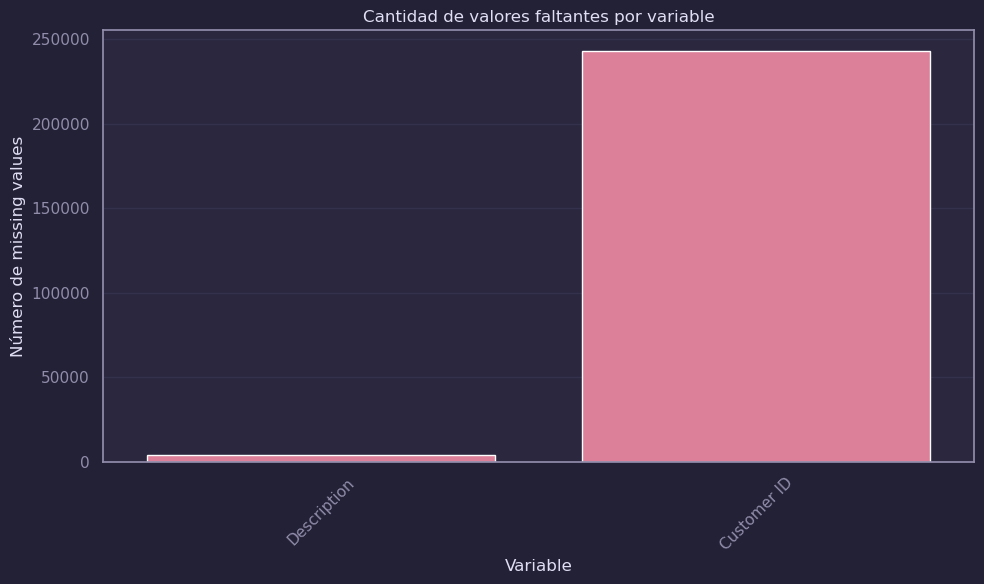

In [5]:
# Contar missing por columna
missing = df.isna().sum().reset_index()
missing.columns = ["Variable", "Missing"]

# Filtrar solo columnas con NaN
missing = missing[missing["Missing"] > 0]

plt.figure(figsize=(10,6))
sns.barplot(data=missing, x="Variable", y="Missing")

plt.xticks(rotation=45)
plt.title("Cantidad de valores faltantes por variable")
plt.ylabel("Número de missing values")
plt.xlabel("Variable")

plt.tight_layout()
plt.savefig('_img/EDA_Missing_Values.png', dpi=300, bbox_inches='tight')
plt.show()


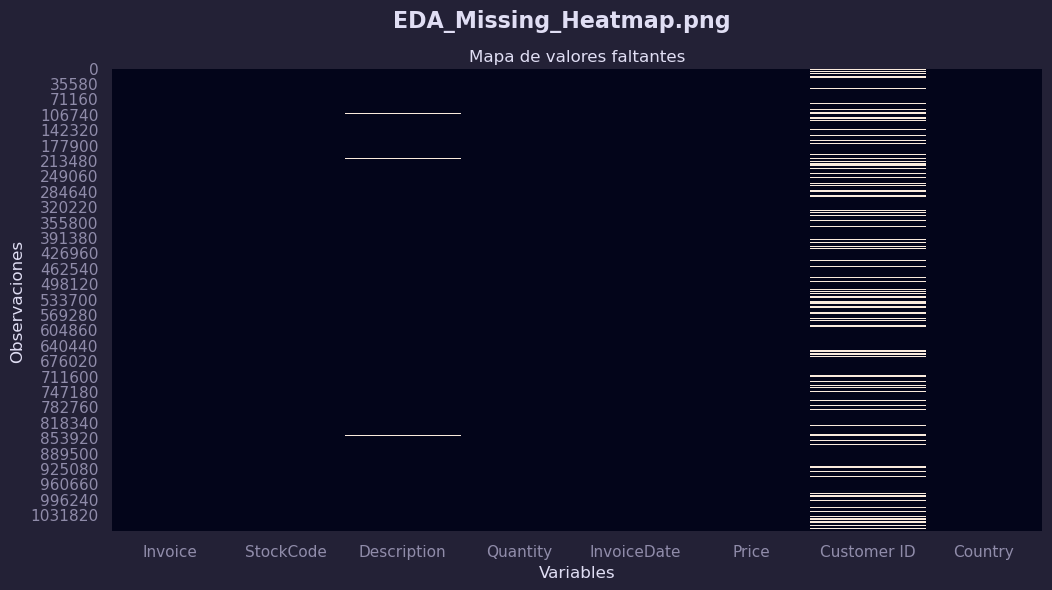

In [6]:
plt.figure(figsize=(12,6))

sns.heatmap(df.isna(), cbar=False)

plt.title("Mapa de valores faltantes")
plt.xlabel("Variables")
plt.ylabel("Observaciones")

plt.suptitle('EDA_Missing_Heatmap.png', fontsize=16, fontweight='bold')
plt.savefig('_img/EDA_Missing_Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
df.shape

(1067371, 8)

In [8]:
df.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


Se usa este comando para ver 20 entradas aleatorias del dataset y ver qué información para saber si los datos están limpios.

In [9]:
df.sample(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
259785,514480,22613,PACK OF 20 SPACEBOY NAPKINS,3,2010-07-02 14:15:00,0.85,16409.0,United Kingdom
1832,489594,84596E,SMALL LICORICE DES PINK BOWL,5,2009-12-01 14:19:00,1.25,15005.0,United Kingdom
1022468,578347,23332,IVORY WICKER HEART LARGE,3,2011-11-24 09:26:00,3.29,NaN,United Kingdom
770683,558614,21383,PACK OF 12 STICKY BUNNIES,3,2011-06-30 15:56:00,0.83,NaN,United Kingdom
761458,557671,71279,PINK GLASS CANDLEHOLDER,6,2011-06-22 10:11:00,2.95,13849.0,United Kingdom
676299,549524,84988,SET OF 72 PINK HEART PAPER DOILIES,1,2011-04-08 15:42:00,2.92,NaN,United Kingdom
820505,562770,22661,CHARLOTTE BAG DOLLY GIRL DESIGN,20,2011-08-09 11:56:00,0.85,17139.0,United Kingdom
622304,544586,22474,SPACEBOY TV DINNER TRAY,2,2011-02-21 15:04:00,4.95,17338.0,United Kingdom
125379,501345,22423,REGENCY CAKESTAND 3 TIER,8,2010-03-16 10:49:00,12.75,15946.0,United Kingdom
307677,519404,22212,FOUR HOOK WHITE LOVEBIRDS,18,2010-08-17 08:56:00,2.10,14646.0,Netherlands


In [10]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


Podemos ver que algunos de los valores de las columnas "Quantity" y "Price" tiene valores negativos en el min, estos valores negativos corresponen a devoluciones o cancelaciones.

In [11]:
df["Country"].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland', 'Saudi Arabia',
       'Czech Republic', 'European Community'], dtype=object)

In [12]:
df["Country"].nunique()

43

In [13]:
df["Country"].value_counts(normalize=True) * 100

Country
United Kingdom          91.938979
EIRE                     1.673832
Germany                  1.651160
France                   1.342551
Netherlands              0.481557
Spain                    0.357045
Switzerland              0.298771
Belgium                  0.292588
Portugal                 0.245463
Australia                0.179225
Channel Islands          0.155897
Italy                    0.143718
Norway                   0.136316
Sweden                   0.127791
Cyprus                   0.110177
Finland                  0.098279
Austria                  0.087879
Denmark                  0.076543
Unspecified              0.070828
Greece                   0.062115
Japan                    0.054526
Poland                   0.050123
USA                      0.050123
United Arab Emirates     0.046844
Israel                   0.034758
Hong Kong                0.034102
Singapore                0.032416
Malta                    0.028013
Iceland                  0.023703
Canada

#### **Top 10 paises por Volumen de Ventas**

Podemos notar que con esta exploración de la variable "Country", que es una variable no numérica, hay 43 paises diferentes entre los clientes que hay en el datasets siendo "United Kingdom" el país que más porcentaje de las ventas realizadas tiene con un 91.93% del total de ellas.

**Calculamos el Total Sales**

In [14]:
country_sales = (
    df.assign(Sales=df["Quantity"] * df["Price"])
      .groupby("Country")["Sales"]
      .sum()
      .reset_index(name="Total_Sales")
      .sort_values("Total_Sales", ascending=False)
)

top_countries = country_sales.head(10)

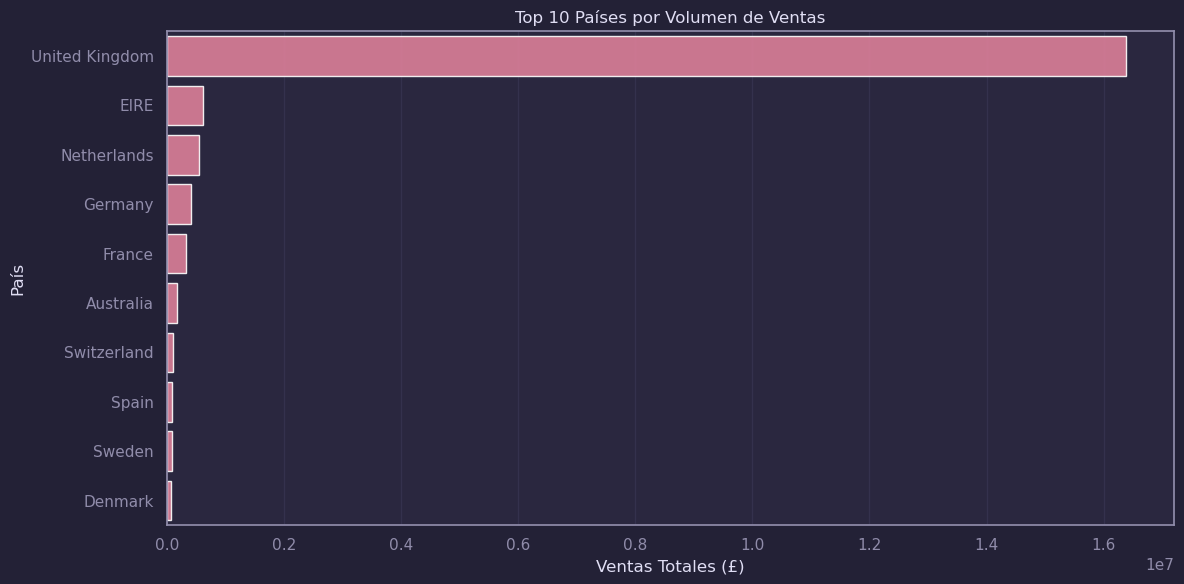

In [15]:

plt.figure(figsize=(12,6))

sns.barplot(
    data=top_countries,
    x="Total_Sales",
    y="Country",
    color=palette[0],
    alpha=0.9
)

plt.title("Top 10 Países por Volumen de Ventas")
plt.xlabel("Ventas Totales (£)")
plt.ylabel("País")

plt.tight_layout()
plt.savefig('_img/EDA_Top10_Paises.png', dpi=300, bbox_inches='tight')
plt.show()


#### **Evolución mensual del número de facturas emitidas**

El gráfico muestra la evolución mensual del número de facturas emitidas entre enero de 2010 y enero de 2012. Se observa un **patrón claramente estacional**, con incrementos significativos en los meses cercanos al final de cada año y descensos marcados al inicio del año siguiente.

En particular, se identifican **picos relevantes en los meses de noviembre y diciembre**, especialmente en diciembre de 2010 y diciembre de 2011, lo que sugiere un aumento considerable de la actividad comercial durante el periodo navideño. Este comportamiento es consistente con el contexto del comercio minorista, donde las campañas de fin de año suelen generar un mayor volumen de pedidos.

Por el contrario, se aprecia una caída pronunciada en los meses posteriores, especialmente en enero de 2011 y enero de 2012, lo que indica una reducción temporal de la demanda tras el periodo de mayor consumo. Este efecto post-estacional refleja una normalización del comportamiento de compra una vez finalizadas las campañas promocionales.

**Durante el resto del año, la serie presenta una variabilidad moderada, con oscilaciones mensuales relativamente estables, lo que sugiere una base de clientes activa y constante.** Sin embargo, existen ligeras fluctuaciones que pueden estar asociadas a factores como promociones puntuales, disponibilidad de productos o cambios en el comportamiento del consumidor.

En conjunto, **este análisis evidencia la presencia de estacionalidad anual en el número de facturas**, siendo un elemento clave a considerar en posteriores etapas del estudio, especialmente en el modelado predictivo y en el análisis de comportamiento de clientes.

In [16]:
print(f"Transactions registered from {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

Transactions registered from 2009-12-01 07:45:00 to 2011-12-09 12:50:00


In [17]:
print(f"Number of transactions registered: {df['Invoice'].nunique()}")

Number of transactions registered: 53628


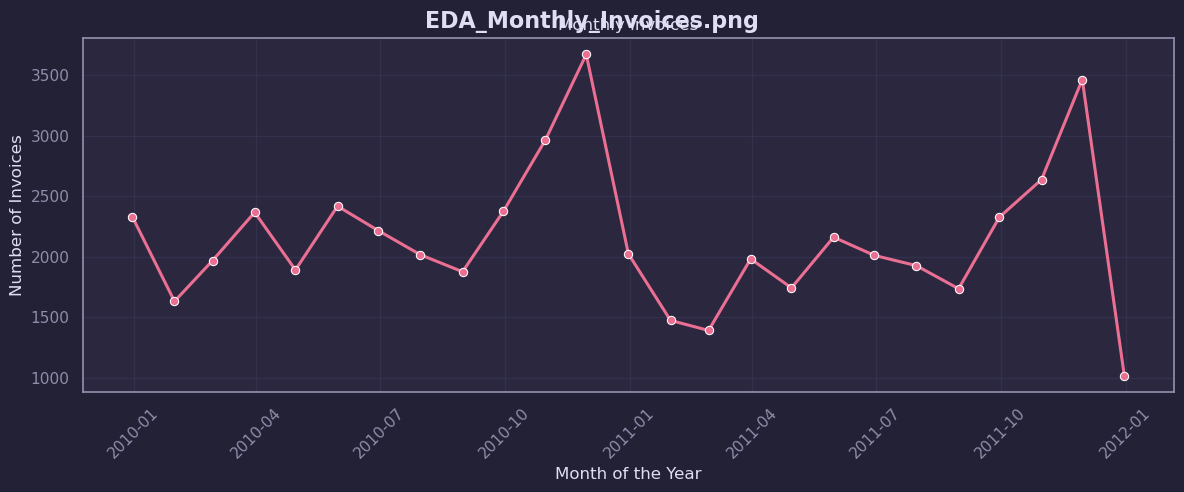

In [18]:
monthly = (
    df
    .groupby(pd.Grouper(key="InvoiceDate", freq="ME"))["Invoice"]
    .nunique()
    .reset_index()
)

plt.figure(figsize=(12,5))

sns.lineplot(
    data=monthly,
    x="InvoiceDate",
    y="Invoice",
    marker="o",
    linewidth=2.2,
)

plt.title("Monthly Invoices")
plt.xlabel("Month of the Year")
plt.ylabel("Number of Invoices")

plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle('EDA_Monthly_Invoices.png', fontsize=16, fontweight='bold')
plt.savefig('_img/EDA_Monthly_Invoices.png', dpi=300, bbox_inches='tight')
plt.show()


#### **Investigando los valores perdidos/nulos en la variable "Description"**

In [19]:
print(f"Valores únicos de Description: {df['Description'].nunique()}")
print(f"Valores únicos de Customer ID: {df['Customer ID'].nunique()}")
print(f"Porcentaje de valores Perdidos en Decription: {df['Description'].isnull().mean() * 100}")

Valores únicos de Description: 5698
Valores únicos de Customer ID: 5942
Porcentaje de valores Perdidos en Decription: 0.4105414143723223


Podemos notar en esta fase inicial de investigación que la columna "Description" tiene el 0.41% de los datos missing. Si hacemos un muestreo de esta columna con 20 datos aleatoreos, podemos notar que **la columna de "Quantity" tiene muchos valores negativos, La columna "Price" tiene muchos "0.0" y los valores de la columna "Customer ID" están perdidos.**

In [20]:
df[df["Description"].isnull()].head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom
4566,489821,85049G,NaN,-240,2009-12-02 13:25:00,0.0,NaN,United Kingdom
6378,489882,35751C,NaN,12,2009-12-02 16:22:00,0.0,NaN,United Kingdom
6555,489898,79323G,NaN,954,2009-12-03 09:40:00,0.0,NaN,United Kingdom
6576,489901,21098,NaN,-200,2009-12-03 09:47:00,0.0,NaN,United Kingdom
6581,489903,21166,NaN,48,2009-12-03 09:57:00,0.0,NaN,United Kingdom


In [21]:
print(f"Todas las filas con Description nulo tienen Customer ID nulo: "
      f"{np.all(df[df['Description'].isnull()]['Customer ID'].isnull())}")
print(f"Porcentaje de Quantity ≤ 0 cuando Description es nulo: "
      f"{(df[df['Description'].isnull()]['Quantity'] <= 0).mean() * 100:.2f}%")
print(f"Todas las filas con Description nulo tienen Country = 'United Kingdom': "
      f"{all(df[df['Description'].isnull()]['Country'] == 'United Kingdom')}")
print(f"Todas las filas con Description nulo tienen Price = 0.0: "
      f"{all(df[df['Description'].isnull()]['Price'] == 0.0)}")


Todas las filas con Description nulo tienen Customer ID nulo: True
Porcentaje de Quantity ≤ 0 cuando Description es nulo: 61.36%
Todas las filas con Description nulo tienen Country = 'United Kingdom': True
Todas las filas con Description nulo tienen Price = 0.0: True


#### **Investigando los valores perdidos/nulos en la variable "Customer ID"**

Notamos que no hay un patron de por qué no hay "Customer ID" en el Dataset

In [22]:
# Máscara para Customer ID nulo
cust_null = df["Customer ID"].isnull()

# Conteo absoluto
null_counts = cust_null.value_counts()

# Porcentaje
null_percent = cust_null.value_counts(normalize=True) * 100

print("Análisis de valores nulos en Customer ID")
print("-" * 40)

print(f"Total de filas con Customer ID nulo: {null_counts.get(True, 0)}")
print(f"Total de filas con Customer ID no nulo: {null_counts.get(False, 0)}")

print(f"Porcentaje con Customer ID nulo: {null_percent.get(True, 0):.2f}%")
print(f"Porcentaje con Customer ID no nulo: {null_percent.get(False, 0):.2f}%")

print(f"Número de descripciones distintas cuando Customer ID es nulo: "
      f"{df[cust_null]['Description'].nunique()}")

print(f"Porcentaje de Quantity ≤ 0 cuando Customer ID es nulo: "
      f"{(df[cust_null]['Quantity'] <= 0).mean() * 100:.2f}%")

print(f"Porcentaje de Price ≤ 0 cuando Customer ID es nulo: "
      f"{(df[cust_null]['Price'] <= 0.0).mean() * 100:.2f}%")


Análisis de valores nulos en Customer ID
----------------------------------------
Total de filas con Customer ID nulo: 243007
Total de filas con Customer ID no nulo: 824364
Porcentaje con Customer ID nulo: 22.77%
Porcentaje con Customer ID no nulo: 77.23%
Número de descripciones distintas cuando Customer ID es nulo: 4872
Porcentaje de Quantity ≤ 0 cuando Customer ID es nulo: 1.73%
Porcentaje de Price ≤ 0 cuando Customer ID es nulo: 2.53%


In [23]:
df[df["Customer ID"].isnull()].sample(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
848273,565234,23200,JUMBO BAG PEARS,1,2011-09-02 09:38:00,4.13,NaN,United Kingdom
322443,520824,22572,ROCKING HORSE GREEN CHRISTMAS,6,2010-08-31 12:30:00,1.66,NaN,United Kingdom
735737,555277,82583,HOT BATHS METAL SIGN,1,2011-06-01 17:30:00,4.13,NaN,United Kingdom
470311,533740,20931,BLUE POT PLANT CANDLE,1,2010-11-18 14:07:00,7.62,NaN,United Kingdom
1016552,578067,22043,CHRISTMAS CARD SCREEN PRINT,1,2011-11-22 15:43:00,0.42,NaN,United Kingdom
919630,570871,22367,CHILDRENS APRON SPACEBOY DESIGN,1,2011-10-12 16:36:00,4.13,NaN,United Kingdom
683418,550215,23194,GYMKHANA TREASURE BOOK BOX,1,2011-04-15 10:43:00,4.58,NaN,United Kingdom
303531,518981,21755,LOVE BUILDING BLOCK WORD,1,2010-08-12 16:41:00,11.87,NaN,United Kingdom
522569,537878,72803B,NaN,1,2010-12-08 18:09:00,0.00,NaN,United Kingdom
491959,535407,21212,PACK OF 72 RETROSPOT CAKE CASES,4,2010-11-26 11:20:00,1.28,NaN,United Kingdom


#### **Investigando los valores negativos en "Price" y "Quantity"**

Hemos detectado un patrón en la construcción del Dataset en el cuál hay una letra C en "Invoice" cuando la cantidad es negativa, cuando "Price" es "0.0" no hay una C en el "Invoice" sin importar su cantidad. Así que teniendo en cuenta esto, vamos a crear una variable que se llame TotalPrice, que vas a ser la multiplicación de "Quantity" y "Price", esto nos dará una valor que usaremos para descartar los pedidos que fueron cancelados.

In [24]:
# Máscara para valores no válidos en Quantity y Price
qty_invalid = df["Quantity"] <= 0
price_invalid = df["Price"] <= 0

print("Análisis de valores no válidos en Quantity y Price")
print("-" * 45)

print(f"Número de filas con Quantity ≤ 0: {qty_invalid.sum()}")
print(f"Número de filas con Price ≤ 0: {price_invalid.sum()}")

print(f"Porcentaje de filas con Quantity ≤ 0: {qty_invalid.mean() * 100:.2f}%")
print(f"Porcentaje de filas con Price ≤ 0: {price_invalid.mean() * 100:.2f}%")

print("\nEjemplos de filas con Quantity ≤ 0:")
display(df[qty_invalid].sample(10))


Análisis de valores no válidos en Quantity y Price
---------------------------------------------
Número de filas con Quantity ≤ 0: 22950
Número de filas con Price ≤ 0: 6207
Porcentaje de filas con Quantity ≤ 0: 2.15%
Porcentaje de filas con Price ≤ 0: 0.58%

Ejemplos de filas con Quantity ≤ 0:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1017596,C578090,POST,POSTAGE,-2,2011-11-22 17:03:00,40.00,12483.0,Sweden
25305,C491521,85069,CREAM SWEETHEART DOUBLE SHELF,-3,2009-12-11 12:29:00,16.95,14895.0,United Kingdom
869844,567058,22453,NaN,-12,2011-09-16 11:40:00,0.00,NaN,United Kingdom
263603,C514848,85232B,SET/3 RUSSIAN DOLL STACKING TINS,-3,2010-07-06 16:10:00,4.25,12709.0,Germany
402136,C527932,22633,HAND WARMER UNION JACK,-1,2010-10-19 13:34:00,2.10,13655.0,United Kingdom
81666,496890,82039C,NaN,-4,2010-02-04 14:16:00,0.00,NaN,United Kingdom
507875,C536825,22617,BAKING SET SPACEBOY DESIGN,-1,2010-12-02 17:27:00,4.95,15384.0,United Kingdom
1055120,C580740,20979,36 PENCILS TUBE RED RETROSPOT,-12,2011-12-06 09:25:00,1.25,12479.0,Germany
821037,C562797,22634,CHILDS BREAKFAST SET SPACEBOY,-1,2011-08-09 14:29:00,8.50,16672.0,United Kingdom
730658,C554715,21231,SWEETHEART CERAMIC TRINKET BOX,-2,2011-05-26 11:02:00,1.25,13658.0,United Kingdom


In [25]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [26]:
df[df["TotalPrice"] <= 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.40
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,-9.90
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,-17.00
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,-12.60
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.40
...,...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25


In [27]:
df[df["TotalPrice"] > 0]["Description"].notnull().all()

np.True_

In [28]:
df[(df["Invoice"].astype("str").str.startswith("C")) & (df["TotalPrice"] > 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom,373.57


In [29]:
df.sample(100)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
834636,564066,21790,VINTAGE SNAP CARDS,12,2011-08-22 15:05:00,0.85,17703.0,United Kingdom,10.20
953428,573406,22086,PAPER CHAIN KIT 50'S CHRISTMAS,6,2011-10-30 15:57:00,2.95,14112.0,United Kingdom,17.70
670915,548893,85131B,BEADED CRYSTAL HEART GREEN ON STICK,1,2011-04-04 15:54:00,0.83,NaN,United Kingdom,0.83
310988,519691,22596,CHRISTMAS STAR WISH LIST CHALKBOARD,1,2010-08-19 13:32:00,0.85,17841.0,United Kingdom,0.85
271800,515768,20660,VIP LUGGAGE TAG,1,2010-07-14 14:30:00,1.25,18096.0,United Kingdom,1.25
...,...,...,...,...,...,...,...,...,...
203938,509041,21219,SET/4 BADGES BALLOON GIRL,10,2010-05-20 10:04:00,1.25,14334.0,United Kingdom,12.50
1039367,579629,23084,RABBIT NIGHT LIGHT,13,2011-11-30 12:16:00,2.08,14963.0,United Kingdom,27.04
119828,500853,21175,GIN + TONIC DIET METAL SIGN,1,2010-03-10 12:22:00,2.10,13566.0,United Kingdom,2.10
991684,C576324,21259,VICTORIAN SEWING BOX SMALL,-1,2011-11-14 15:10:00,5.95,16161.0,United Kingdom,-5.95


In [30]:
df[(df["StockCode"] == "M") & (df["TotalPrice"] >= 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
2697,489609,M,Manual,1,2009-12-01 14:50:00,4.00,NaN,United Kingdom,4.00
11310,490300,M,Manual,1,2009-12-04 14:19:00,0.85,12970.0,United Kingdom,0.85
11311,490300,M,Manual,1,2009-12-04 14:19:00,0.21,12970.0,United Kingdom,0.21
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.00,17231.0,United Kingdom,0.00
17386,490760,M,Manual,1,2009-12-08 09:49:00,10.00,14295.0,United Kingdom,10.00
...,...,...,...,...,...,...,...,...,...
1051476,580645,M,Manual,1,2011-12-05 13:11:00,219.50,17857.0,United Kingdom,219.50
1051479,580646,M,Manual,800,2011-12-05 13:13:00,0.25,17857.0,United Kingdom,200.00
1056337,580884,M,Manual,1,2011-12-06 12:21:00,0.85,15907.0,United Kingdom,0.85
1056893,580956,M,Manual,4,2011-12-06 14:23:00,1.25,17841.0,United Kingdom,5.00


# **Preparación y Limpieza del Dataset**

Para hacer un análisis que nos hemos propuesto desde el principio, debemos limpiar el dataset y cumplir ciertas normas para que nuestos cálculos sean válidos. Dentro de esta preparación debemos asegurarnos de que:

1. Las Columanos con valores "Missing" deben haber sido eliminadas, esto está ligado al  que sin "Customer ID" no podemos construir su historial

2. Los invoices que tiene una "C" al inicio de la cadena han sido eliminados.

3. Todas las ventas que tiene el precio en 0.00 han sido eliminadas de dataset.

In [31]:
df = df.query("TotalPrice > 0")

df = df[df["Customer ID"].notna()]

df = df[~df["Invoice"].astype("string").str.startswith("C", na=False)]
df = df[~df["StockCode"].astype("string").str.contains("TEST", na=False)]

df = df.drop_duplicates()

assert (df["InvoiceDate"] > datetime(2009,1,1)).all()
assert (df["InvoiceDate"] < datetime(2012,1,1)).all()

In [32]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85


In [33]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.5
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.6
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 779415 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779415 non-null  object        
 1   StockCode    779415 non-null  object        
 2   Description  779415 non-null  object        
 3   Quantity     779415 non-null  int64         
 4   InvoiceDate  779415 non-null  datetime64[ns]
 5   Price        779415 non-null  float64       
 6   Customer ID  779415 non-null  float64       
 7   Country      779415 non-null  object        
 8   TotalPrice   779415 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 59.5+ MB


### **Ventas totales por mes**

In [35]:
# Creación de una variable mensual 
df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")

#Calcular ventas por mes
monthly_sales = (
    df.groupby("YearMonth")["TotalPrice"]
      .sum()
      .reset_index()
)

#Convirtiendo a una fecha real para poder graficar
monthly_sales["YearMonth"] = monthly_sales["YearMonth"].dt.to_timestamp()

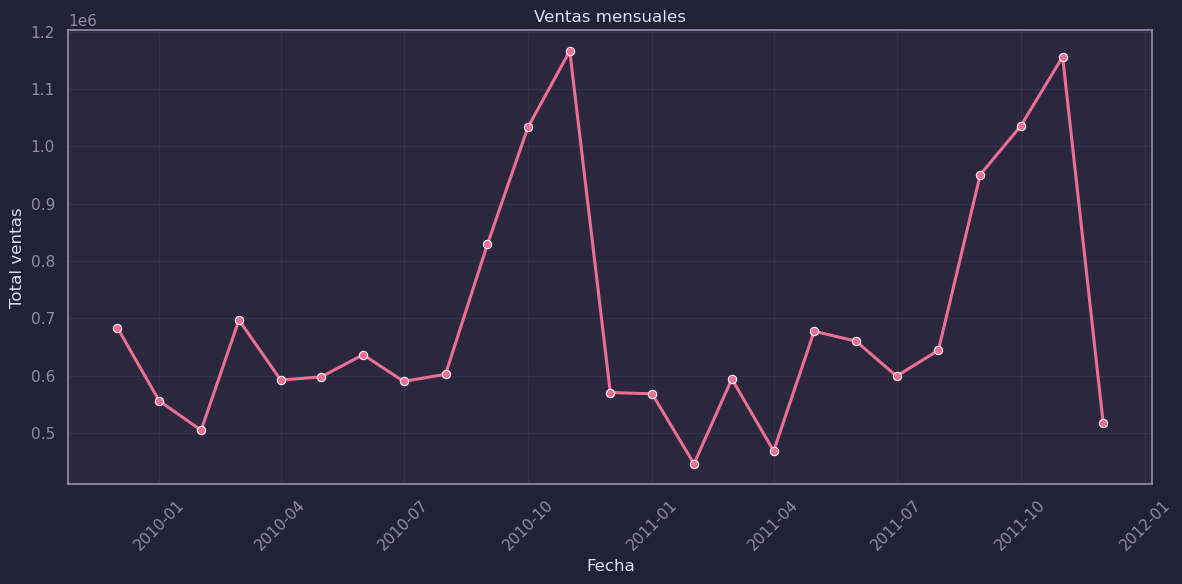

In [36]:
plt.figure(figsize=(12,6))

sns.lineplot(
    data=monthly_sales,
    x="YearMonth",
    y="TotalPrice",
    marker="o",
    linewidth=2.2,
)


plt.title("Ventas mensuales")
plt.xlabel("Fecha")
plt.ylabel("Total ventas")

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('_img/EDA_Ventas_Mensuales.png', dpi=300, bbox_inches='tight')
plt.show()


# **4. Ingeniería de Características (RFM)**

Este análisis va a necesitar ciertas variables llamadas "Recency, Frequency, Monetary", estas nos ayudarán a agrupar clientes basandonos en sus historial de compras.

1. **Recency:** Esta variable indíca cuando fue la última transacción del cliente.
2. **Frequency:** Es el número total de transacciones / compras.
3. **Monetary:** Cantidad de dinero gastada por cliente.

Como se necesita crear un dataframe para cada cliente no podíamos hacer esto con los clientes que no tuvieran "Customer ID".

In [37]:
from datetime import timedelta

fecha_referencia = df["InvoiceDate"].max() + timedelta(days=1)
print(fecha_referencia)

2011-12-10 12:50:00


### **Construcción de variables RFM**

In [38]:
rfm = (
    df.groupby("Customer ID")
      .agg(
          recency=("InvoiceDate", lambda x: (fecha_referencia - x.max()).days),
          frequency=("Invoice", "nunique"),
          monetary=("TotalPrice", "sum")
      )
      .reset_index(drop=False)   # mantiene Customer ID como columna
)

rfm.head()


,Customer ID,recency,frequency,monetary
0,12346.0,326,3,77352.96
1,12347.0,2,8,4921.53
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


In [39]:
rfm.describe()

,Customer ID,recency,frequency,monetary
count,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,201.331916,6.287683,2955.865646
std,1715.572666,209.338707,13.009300,14440.674831
min,12346.000000,1.000000,1.000000,2.950000
25%,13833.250000,26.000000,1.000000,342.280000
50%,15314.500000,96.000000,3.000000,867.740000
75%,16797.750000,380.000000,7.000000,2248.305000
max,18287.000000,739.000000,398.000000,580987.040000


#### **Gráfico: Distribución de RFM (Sin outliers en el percentil 98.5%)**

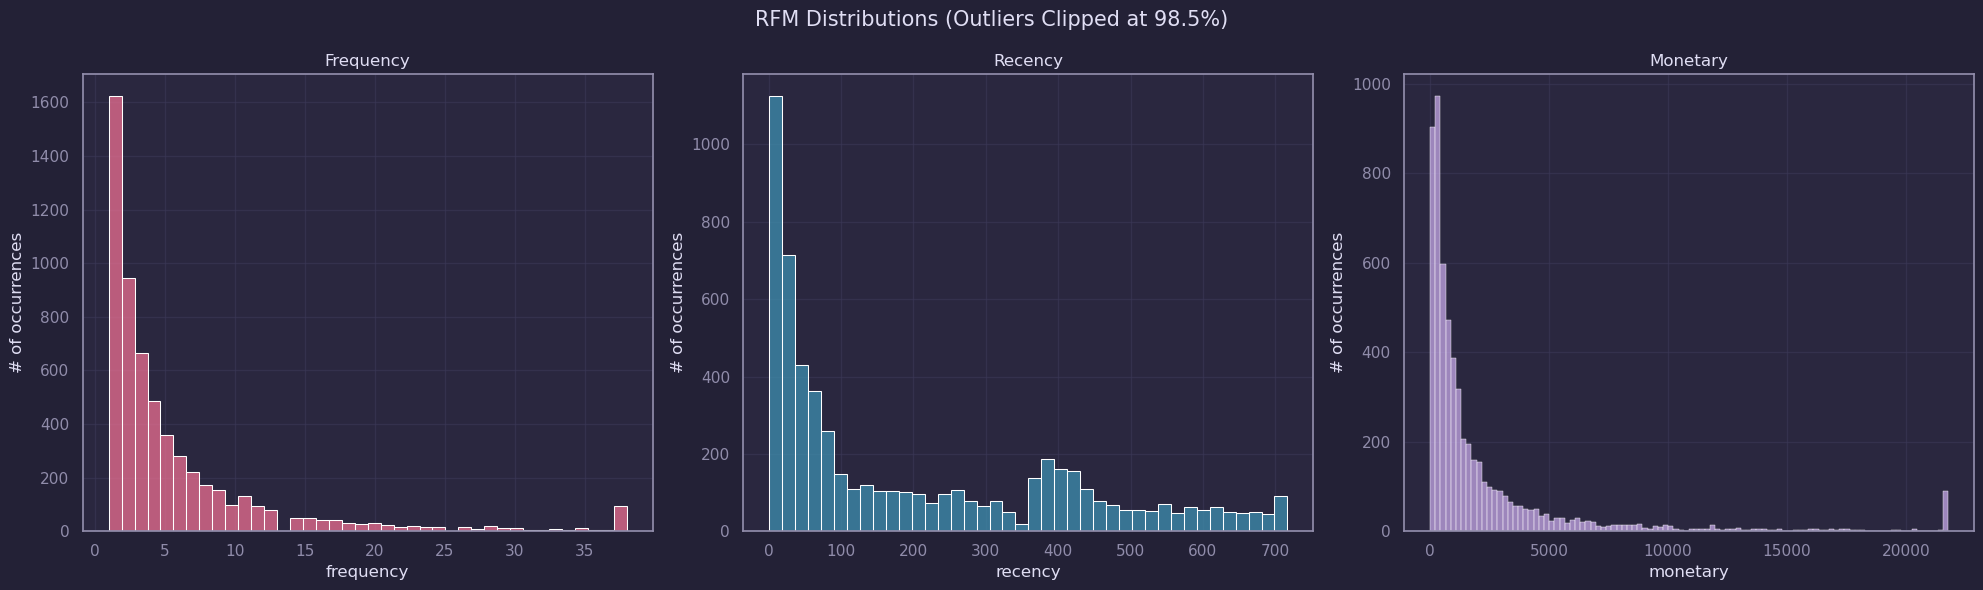

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for a in ax:
    a.set_ylabel("# of occurrences")

# Frequency (clipped solo para visualización)
sns.histplot(
    rfm["frequency"].clip(upper=rfm["frequency"].quantile(0.985)),
    bins=40,
    color=palette[0],
    ax=ax[0]
)
ax[0].set_title("Frequency")

# Recency (clipped solo para visualización)
sns.histplot(
    rfm["recency"].clip(upper=rfm["recency"].quantile(0.985)),
    bins=40,
    color=palette[1],
    ax=ax[1]
)
ax[1].set_title("Recency")

# Monetary (clipped solo para visualización)
sns.histplot(
    rfm["monetary"].clip(upper=rfm["monetary"].quantile(0.985)),
    bins=100,
    color=palette[3],
    ax=ax[2]
)
ax[2].set_title("Monetary")

plt.suptitle("RFM Distributions (Outliers Clipped at 98.5%)", fontsize=15)
plt.tight_layout()
plt.savefig('_img/RFM_Distributions_Clipped.png', dpi=300, bbox_inches='tight')
plt.show()

Estos datos son **asimétricos a simple vista, pero necesitamos saber si realmente lo están.** Así que medimos numerícamente esto.

In [41]:
rfm[["recency", "frequency", "monetary"]].skew()

recency       0.887198
frequency    12.640634
monetary     25.070933
dtype: float64

### **Transformación logarítmica de datos altamente sesgados**

Necesitamos transformar obligatoriamente estos datos debido a que están fuermente sesgadoz.

In [42]:
# Transformación logarítmica como columnas nuevas dentro de rfm
rfm["recency_log"] = np.log1p(rfm["recency"])
rfm["frequency_log"] = np.log1p(rfm["frequency"])
rfm["monetary_log"] = np.log1p(rfm["monetary"])

Se optó por la **transformación logarítmica** por su mayor estabilidad, interpretabilidad y mejor comportamiento **en variables discretas como Frequency**

In [43]:
rfm[["recency_log", "frequency_log", "monetary_log"]].skew()

recency_log     -0.488631
frequency_log    1.002399
monetary_log     0.265525
dtype: float64

#### **Gráfico: Distribución de RFM (En escala logarítmica)**

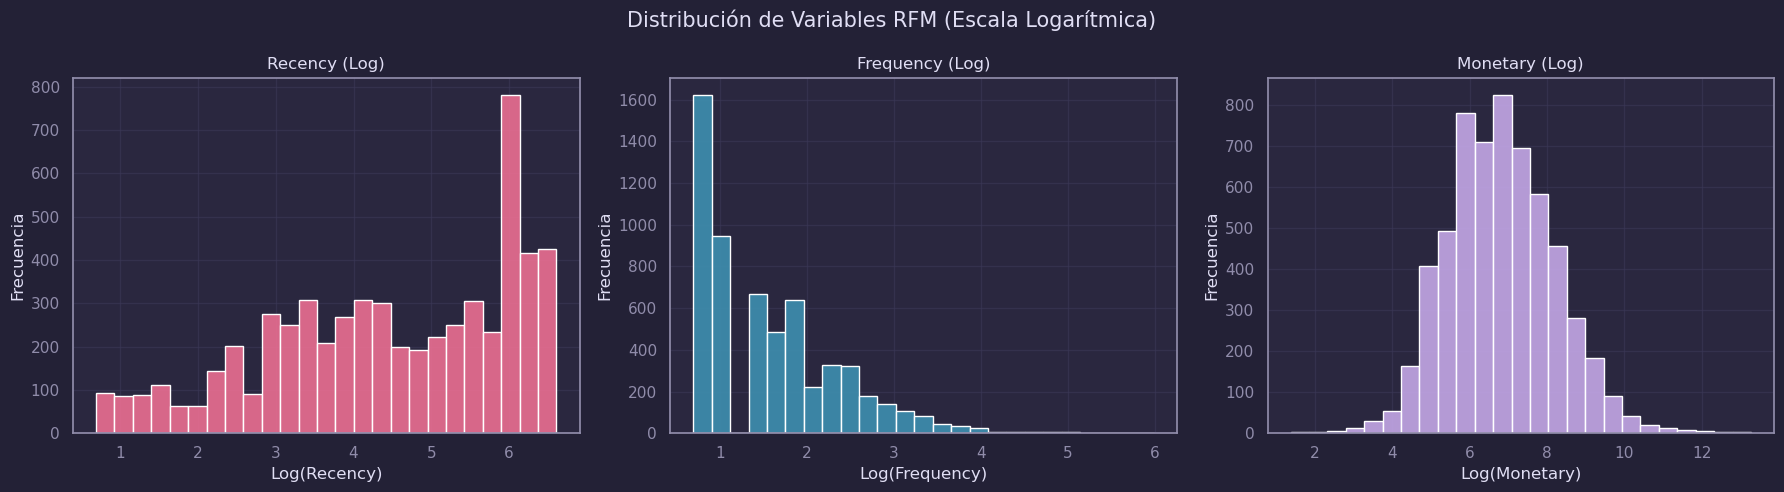

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency (log)
sns.histplot(rfm["recency_log"], bins=25, color=palette[0], alpha=0.9, ax=axes[0])
axes[0].set_title("Recency (Log)")
axes[0].set_xlabel("Log(Recency)")
axes[0].set_ylabel("Frecuencia")

# Frequency (log)
sns.histplot(rfm["frequency_log"], bins=25, color=palette[1], alpha=0.9, ax=axes[1])
axes[1].set_title("Frequency (Log)")
axes[1].set_xlabel("Log(Frequency)")
axes[1].set_ylabel("Frecuencia")

# Monetary (log)
sns.histplot(rfm["monetary_log"], bins=25, color=palette[3], alpha=0.9, ax=axes[2])
axes[2].set_title("Monetary (Log)")
axes[2].set_xlabel("Log(Monetary)")
axes[2].set_ylabel("Frecuencia")

plt.suptitle("Distribución de Variables RFM (Escala Logarítmica)", fontsize=15)
plt.tight_layout()
plt.savefig('_img/RFM_Log_Distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### **Escalado de datos StandardScaler()**

In [45]:
scaler = StandardScaler()

log_cols = ["recency_log", "frequency_log", "monetary_log"]
sc_cols  = ["recency_sc",  "frequency_sc",  "monetary_sc"]

rfm[sc_cols] = scaler.fit_transform(rfm[log_cols])

In [46]:
rfm[sc_cols].shape

(5878, 3)

#### **Gráfico: Distribución de Variables RFM (Estandarizadas**)

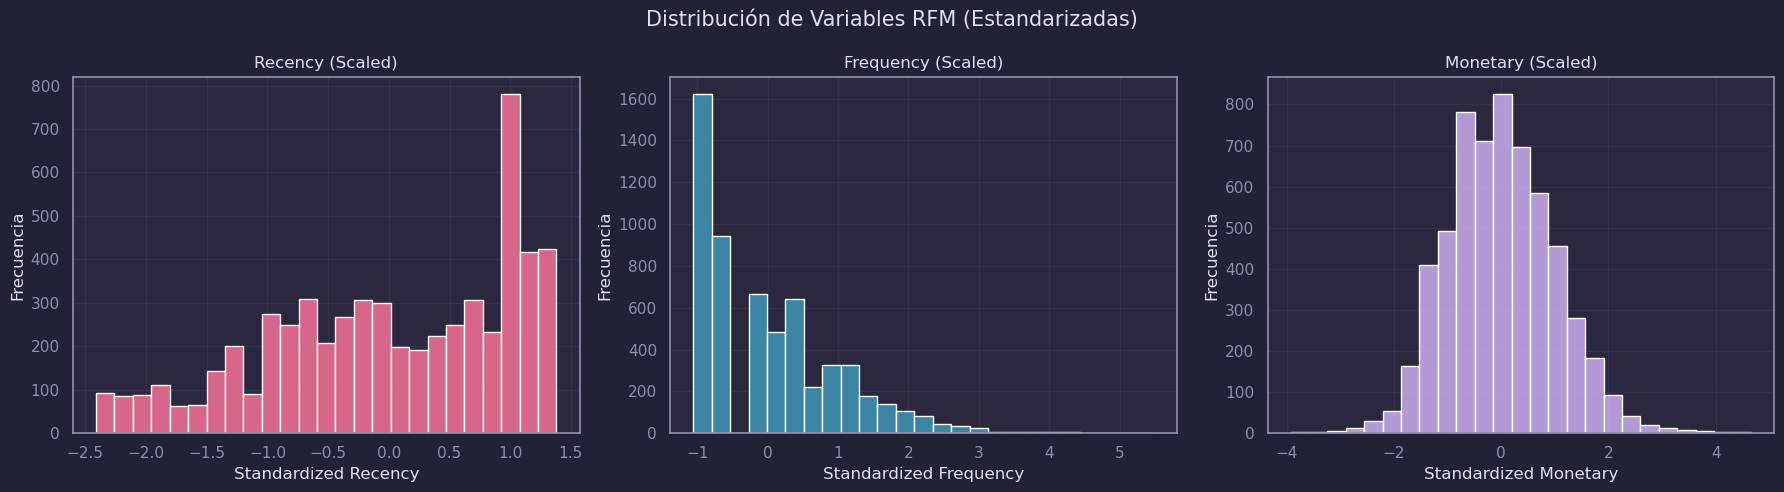

In [47]:
colors = [palette[0], palette[1], palette[3]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, color in zip(axes, sc_cols, colors):
    sns.histplot(rfm[col], bins=25, color=color, alpha=0.9, ax=ax)
    ax.set_title(col.replace("_sc", " (Scaled)").title())
    ax.set_xlabel(f"Standardized {col.split('_')[0].title()}")
    ax.set_ylabel("Frecuencia")

plt.suptitle("Distribución de Variables RFM (Estandarizadas)", fontsize=15)
plt.tight_layout()
plt.savefig('_img/RFM_Standardized_Distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# **5. SEGMENTACIÓN DE CLIENTES**

Nuestro paso siguiente va a ser usar el algorítmo **KMeans de Scikit-learn**, así vamos a encontrar qué tipo de clusters hay en todos estos datos.

### **The Silhouette method**

In [48]:
k_values = range(2, 11)
X = rfm[sc_cols]

In [49]:
silhouette_scores = []

for k in k_values:
    
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    
    labels = kmeans.fit_predict(X)
    
    score = silhouette_score(X, labels)
    
    silhouette_scores.append(score)


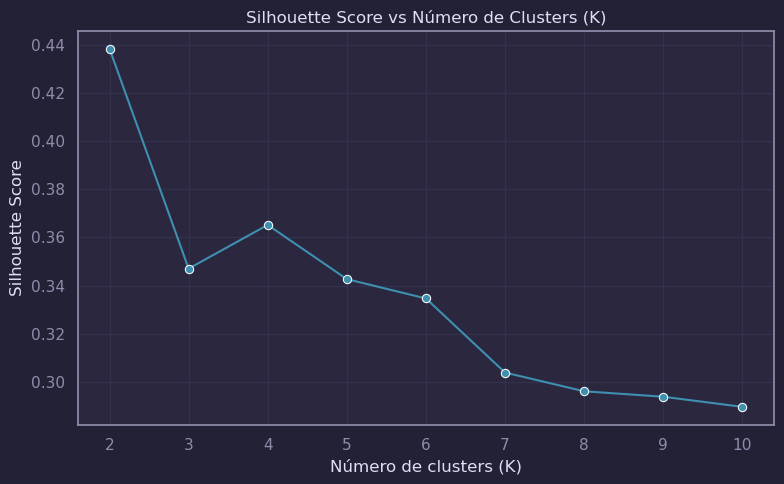

In [50]:
palette = use_rose_pine_moon_sns()

plt.figure(figsize=(8,5))

sns.lineplot(
    x=list(k_values),
    y=silhouette_scores,
    marker="o",
    color=palette[1]
)

plt.title("Silhouette Score vs Número de Clusters (K)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette Score")

plt.xticks(list(k_values))

plt.tight_layout()
plt.savefig('_img/KMeans_Silhouette.png', dpi=300, bbox_inches='tight')
plt.show()


### **Calinski–Harabasz**

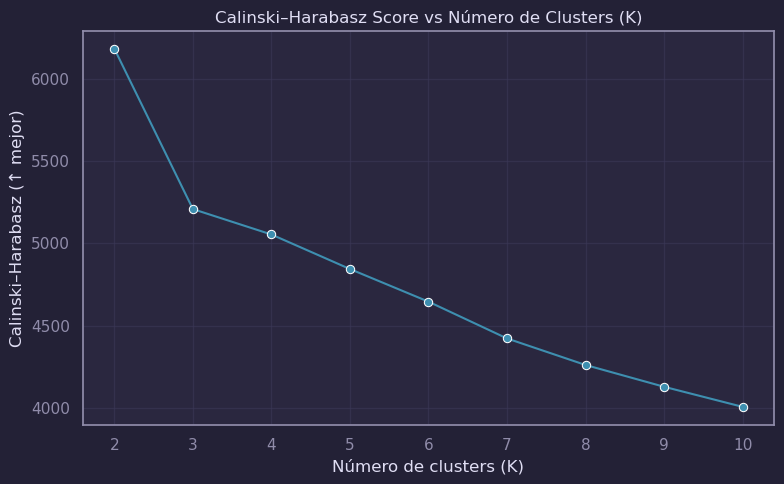

In [51]:
ch_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    ch_scores.append(calinski_harabasz_score(X, labels))

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_values), y=ch_scores, marker="o", color=palette[1])

plt.title("Calinski–Harabasz Score vs Número de Clusters (K)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Calinski–Harabasz (↑ mejor)")
plt.xticks(list(k_values))

plt.tight_layout()
plt.savefig('_img/KMeans_CalinskiHarabasz.png', dpi=300, bbox_inches='tight')
plt.show()


### **Davies-Bouldin**

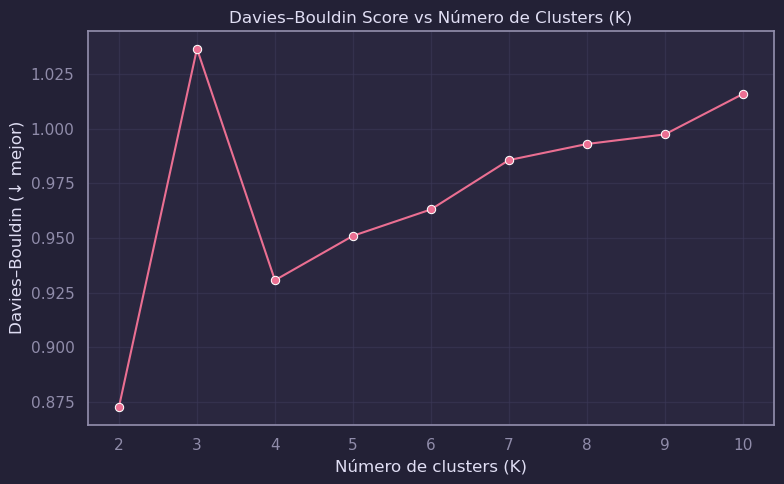

In [52]:
db_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    db_scores.append(davies_bouldin_score(X, labels))

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_values), y=db_scores, marker="o", color=palette[0])

plt.title("Davies–Bouldin Score vs Número de Clusters (K)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Davies–Bouldin (↓ mejor)")
plt.xticks(list(k_values))

plt.tight_layout()
plt.savefig('_img/KMeans_DaviesBouldin.png', dpi=300, bbox_inches='tight')
plt.show()


### **Método del Codo**

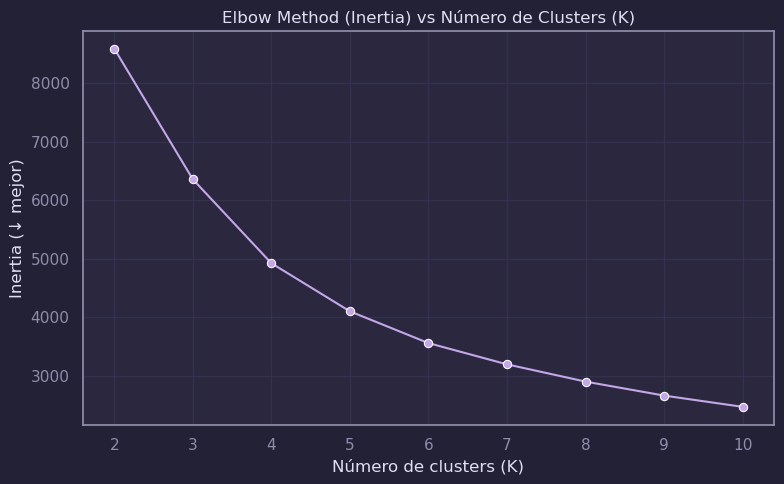

In [53]:
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_values), y=inertias, marker="o", color=palette[3])

plt.title("Elbow Method (Inertia) vs Número de Clusters (K)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inertia (↓ mejor)")
plt.xticks(list(k_values))

plt.tight_layout()
plt.savefig('_img/KMeans_Elbow.png', dpi=300, bbox_inches='tight')
plt.show()


### **Comparación de gráficos**

Las métricas Silhouette, Calinski–Harabasz y Davies–Bouldin indican un valor óptimo en K=2. No obstante, el método del codo sugiere una **solución alternativa en K=4**, que permite una segmentación más detallada desde el punto de vista de negocio.

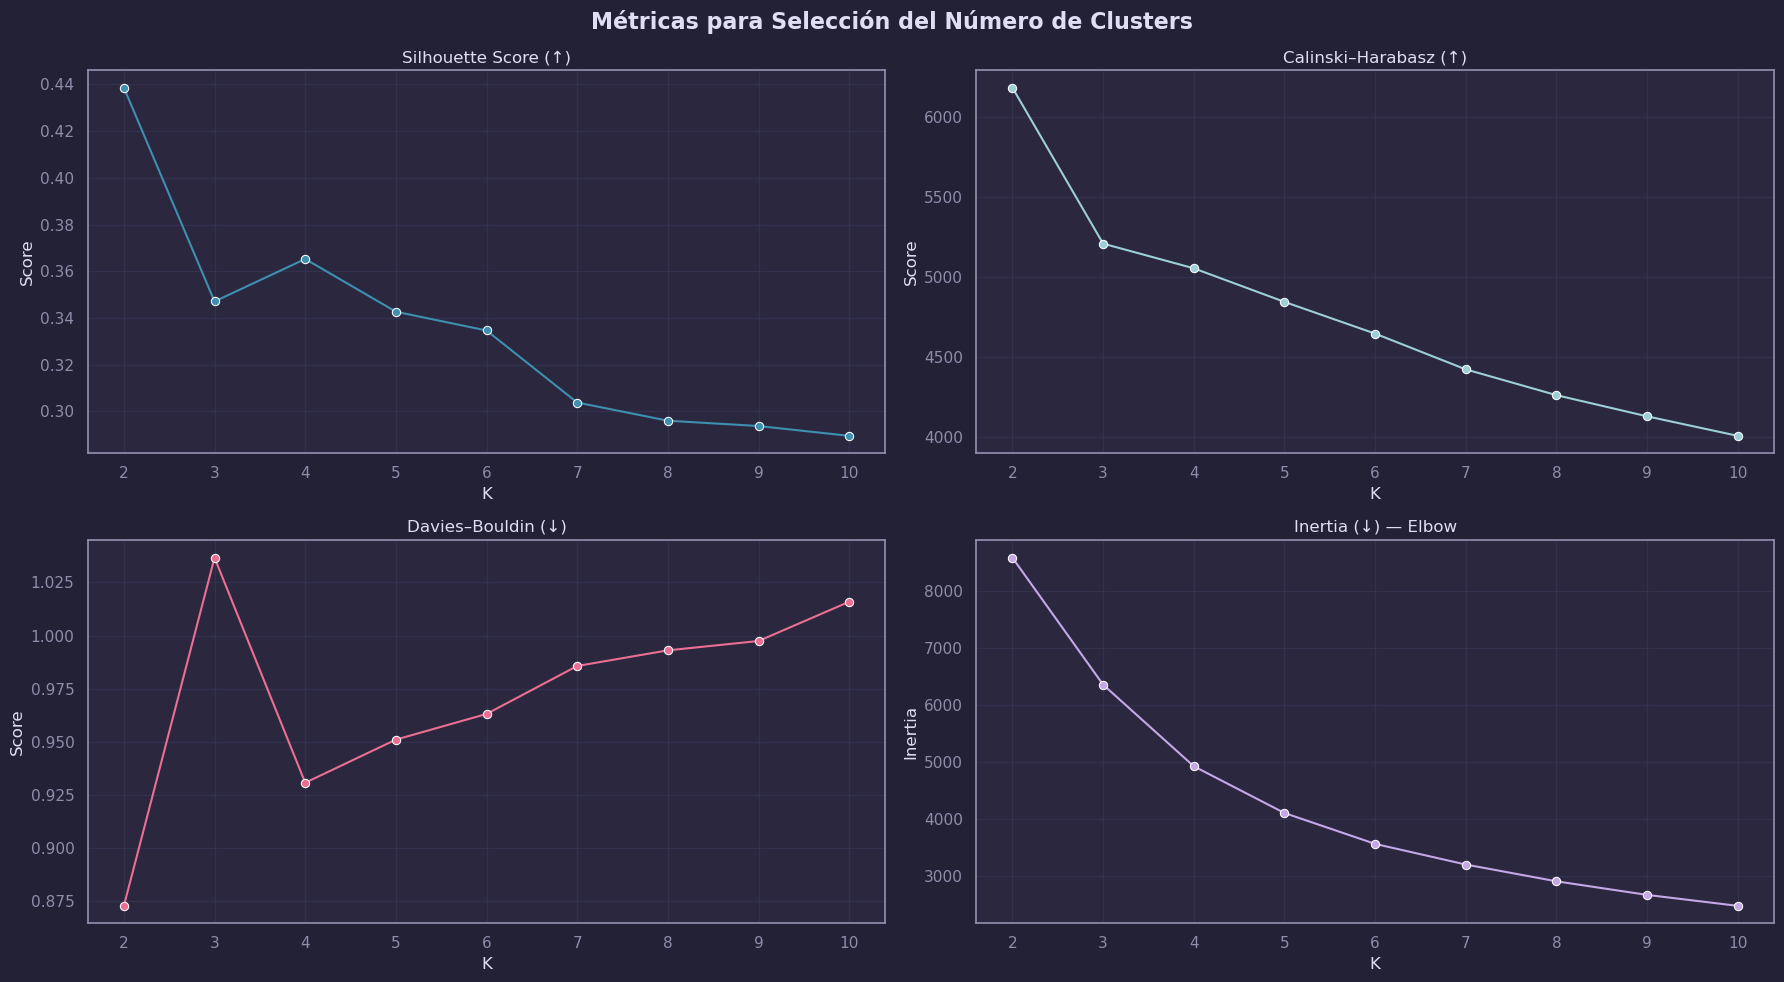

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# 1) Silhouette (↑ mejor)
sns.lineplot(x=list(k_values), y=silhouette_scores, marker="o", color=palette[1], ax=axes[0, 0])
axes[0, 0].set_title("Silhouette Score (↑)")
axes[0, 0].set_xlabel("K")
axes[0, 0].set_ylabel("Score")
axes[0, 0].set_xticks(list(k_values))

# 2) Calinski–Harabasz (↑ mejor)
sns.lineplot(x=list(k_values), y=ch_scores, marker="o", color=palette[2], ax=axes[0, 1])
axes[0, 1].set_title("Calinski–Harabasz (↑)")
axes[0, 1].set_xlabel("K")
axes[0, 1].set_ylabel("Score")
axes[0, 1].set_xticks(list(k_values))

# 3) Davies–Bouldin (↓ mejor)
sns.lineplot(x=list(k_values), y=db_scores, marker="o", color=palette[0], ax=axes[1, 0])
axes[1, 0].set_title("Davies–Bouldin (↓)")
axes[1, 0].set_xlabel("K")
axes[1, 0].set_ylabel("Score")
axes[1, 0].set_xticks(list(k_values))

# 4) Inertia (↓ mejor) — Elbow
sns.lineplot(x=list(k_values), y=inertias, marker="o", color=palette[3], ax=axes[1, 1])
axes[1, 1].set_title("Inertia (↓) — Elbow")
axes[1, 1].set_xlabel("K")
axes[1, 1].set_ylabel("Inertia")
axes[1, 1].set_xticks(list(k_values))

plt.suptitle("Métricas para Selección del Número de Clusters", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('_img/KMeans_All_Metrics.png', dpi=300, bbox_inches='tight')
plt.show()


In [55]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["cluster"] = kmeans.fit_predict(rfm[sc_cols])

# Reportar métricas finales del modelo elegido (K=4)
print(f"Silhouette Score (K=4):    {silhouette_score(rfm[sc_cols], rfm['cluster']):.4f}")
print(f"Calinski-Harabasz (K=4):   {calinski_harabasz_score(rfm[sc_cols], rfm['cluster']):.4f}")
print(f"Davies-Bouldin (K=4):      {davies_bouldin_score(rfm[sc_cols], rfm['cluster']):.4f}")

Silhouette Score (K=4):    0.3652
Calinski-Harabasz (K=4):   5054.2432
Davies-Bouldin (K=4):      0.9307


In [56]:
# ─── Exportar modelos KMeans y Scaler ───
import joblib

joblib.dump(kmeans, '_models/kmeans_model.pkl')
joblib.dump(scaler, '_models/scaler.pkl')

print("✓ KMeans guardado en _models/kmeans_model.pkl")
print("✓ Scaler guardado en _models/scaler.pkl")


✓ KMeans guardado en _models/kmeans_model.pkl
✓ Scaler guardado en _models/scaler.pkl


In [57]:
rfm.head()

,Customer ID,recency,frequency,monetary,recency_log,frequency_log,monetary_log,recency_sc,frequency_sc,monetary_sc,cluster
0,12346.0,326,3,77352.96,5.789960,1.386294,11.256147,0.856701,-0.201482,3.203106,3
1,12347.0,2,8,4921.53,1.098612,2.197225,8.501578,-2.151979,0.800563,1.215625,2
2,12348.0,75,5,2019.40,4.330733,1.791759,7.611051,-0.079138,0.299540,0.573090,3
3,12349.0,19,4,4428.69,2.995732,1.609438,8.396085,-0.935308,0.074250,1.139509,0
4,12350.0,310,1,334.40,5.739793,0.693147,5.815324,0.824527,-1.057986,-0.722566,1


In [58]:
rfm["cluster"].value_counts()

cluster
1    1974
3    1463
0    1250
2    1191
Name: count, dtype: int64

In [59]:
rfm.groupby("cluster").mean()

,Customer ID,recency,frequency,monetary,recency_log,frequency_log,monetary_log,recency_sc,frequency_sc,monetary_sc
cluster,,,,,,,,,,
0,15308.853600,28.314400,3.050400,855.508946,3.069440,1.316067,6.511232,-0.888038,-0.288260,-0.220453
1,15383.545593,395.145897,1.377913,317.749089,5.813730,0.837026,5.510953,0.871945,-0.880199,-0.942176
2,15269.118388,27.298069,19.312343,10699.880636,2.761601,2.762572,8.659161,-1.085462,1.499148,1.329324
3,15266.375256,229.327409,5.075188,2005.739951,5.180599,1.722131,7.339890,0.465902,0.213502,0.377441


Para mejorar la legibilidad, en Frequency y Monetary se aplicó un recorte visual de valores extremos (solo para visualización), manteniendo el dataset completo para el entrenamiento del modelo

#### **Gráfico: Distribuciones de las variables RFM**

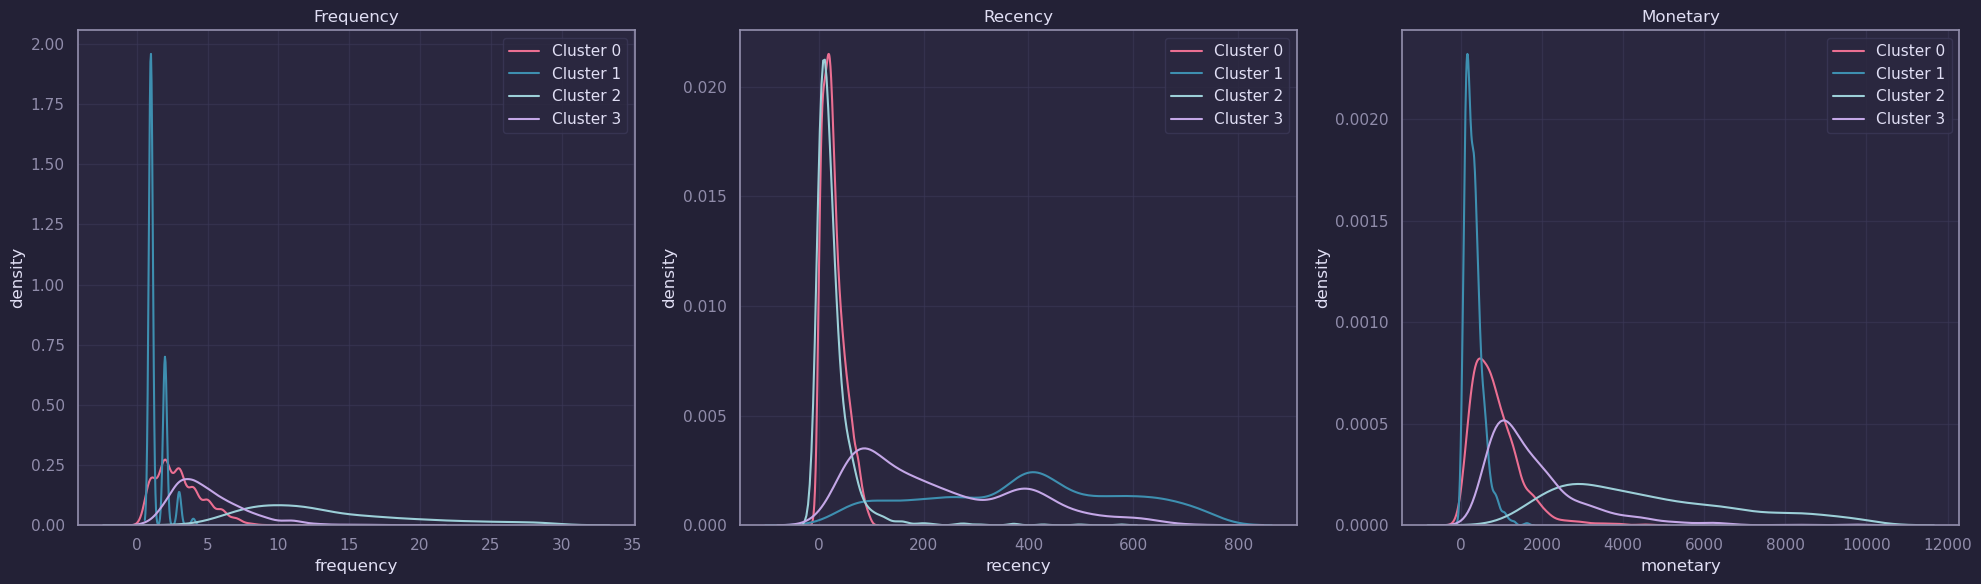

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for a in ax:
    a.set_ylabel("density")

for c in sorted(rfm["cluster"].unique()):
    rfm_c = rfm[rfm["cluster"] == c]
    label = f"Cluster {c}"

    # Frequency (recortado)
    sns.kdeplot(
        data=rfm_c.query("frequency < 30"),
        x="frequency",
        ax=ax[0],
        label=label,
        common_norm=False
    )

    # Recency (sin recorte)
    sns.kdeplot(
        data=rfm_c,
        x="recency",
        ax=ax[1],
        label=label,
        common_norm=False
    )

    # Monetary (recortado)
    sns.kdeplot(
        data=rfm_c.query("monetary < 10000"),
        x="monetary",
        ax=ax[2],
        label=label,
        common_norm=False
    )

ax[0].set_title("Frequency")
ax[1].set_title("Recency")
ax[2].set_title("Monetary")

for a in ax:
    a.legend()

plt.tight_layout()
plt.savefig('_img/RFM_Boxplots_by_Cluster.png', dpi=300, bbox_inches='tight')
plt.show()


#### **Gráfico: Distribuciones de las variables RFM escaladas (KDE) por cluster**

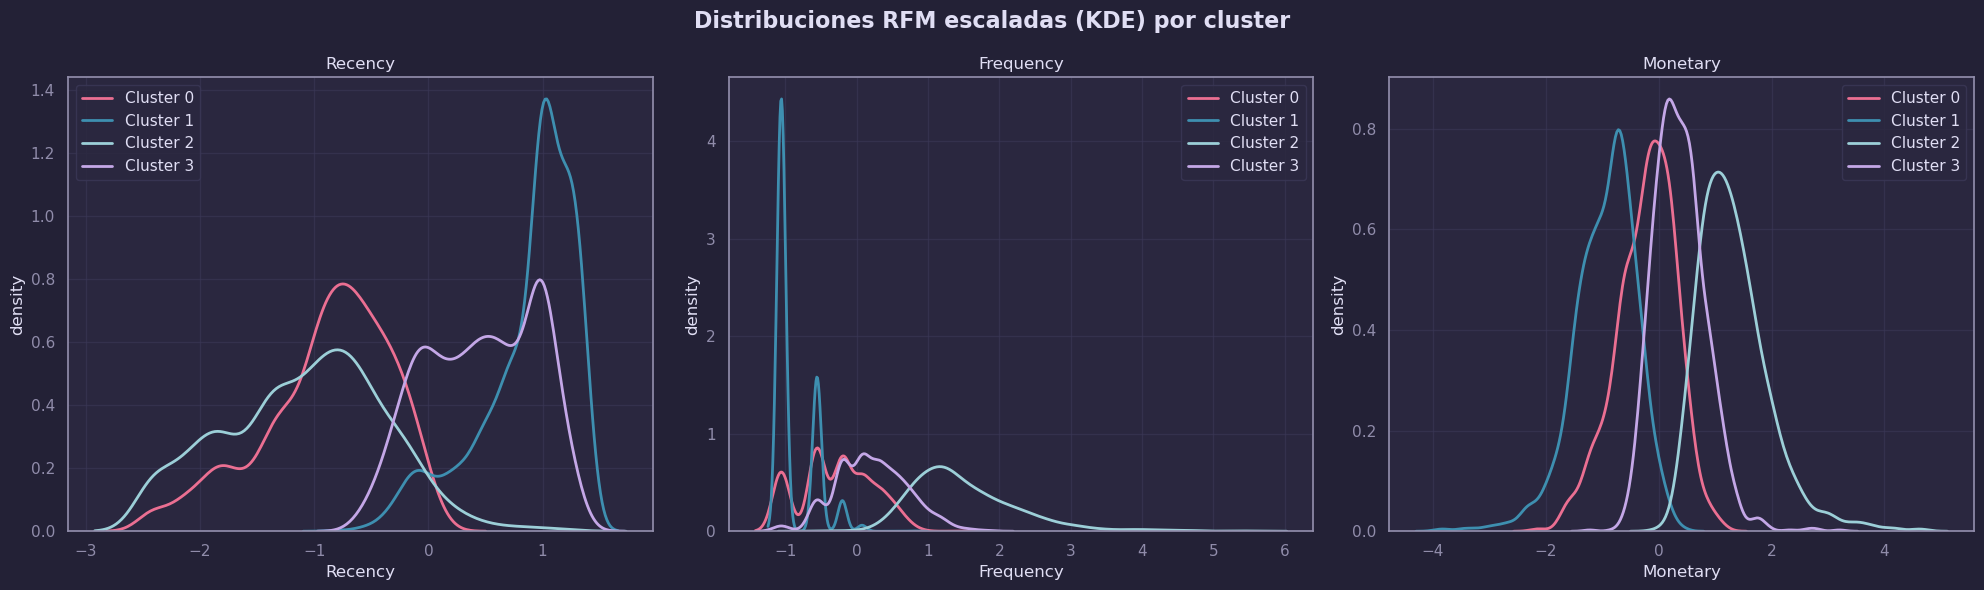

In [61]:
# Plot KDE de distribuciones escaladas por cluster (directamente desde rfm)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, col in zip(axes, sc_cols):
    nice_name = col.replace("_sc", "").title()
    ax.set_title(nice_name)
    ax.set_xlabel(nice_name)
    ax.set_ylabel("density")

    for c in sorted(rfm["cluster"].unique()):
        sns.kdeplot(
            data=rfm[rfm["cluster"] == c],
            x=col,
            ax=ax,
            label=f"Cluster {c}",
            linewidth=2
        )

    ax.legend()

plt.suptitle("Distribuciones RFM escaladas (KDE) por cluster", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('_img/RFM_KDE_by_Cluster.png', dpi=300, bbox_inches='tight')
plt.show()

#### **Asignación de nombres a los segmentos basados en los centroides**

Tras aplicar la segmentación mediante el algoritmo K-Means sobre las variables Recency, Frequency y Monetary (previamente transformadas mediante logaritmo y estandarizadas), se identificaron cuatro grupos principales de clientes. La selección del número de clusters se realizó considerando métricas internas de validación y criterios de interpretabilidad empresarial.

A continuación, se analizan las características de cada segmento a partir de los valores medios de las variables RFM y de las distribuciones obtenidas mediante estimaciones de densidad (KDE).

In [62]:
# Verificar centroides antes de etiquetar
centroids = rfm.groupby("cluster")[["recency","frequency","monetary"]].mean()
print("Centroides por cluster:")
print(centroids)
print()

# Asignar nombres basándose en los centroides reales
# El cluster con menor recency + mayor frequency + mayor monetary = Premium
# El cluster con mayor recency + menor frequency = Lost y así...

premium_id  = centroids["monetary"].idxmax()
lost_id     = centroids["recency"].idxmax()
remaining   = [c for c in centroids.index if c not in [premium_id, lost_id]]
potential_id = centroids.loc[remaining, "frequency"].idxmax()
occasional_id = [c for c in remaining if c != potential_id][0]

cluster_names = {
    premium_id:    "Premium",
    lost_id:       "Lost",
    occasional_id: "Occasional",
    potential_id:  "Potential"
}

print("Asignación automática de nombres:")
for k, v in cluster_names.items():
    print(f"  Cluster {k} → {v}")

rfm["segment"] = rfm["cluster"].map(cluster_names)

Centroides por cluster:
            recency  frequency      monetary
cluster                                     
0         28.314400   3.050400    855.508946
1        395.145897   1.377913    317.749089
2         27.298069  19.312343  10699.880636
3        229.327409   5.075188   2005.739951

Asignación automática de nombres:
  Cluster 2 → Premium
  Cluster 1 → Lost
  Cluster 0 → Occasional
  Cluster 3 → Potential


In [63]:
rfm

,Customer ID,recency,frequency,monetary,recency_log,frequency_log,monetary_log,recency_sc,frequency_sc,monetary_sc,cluster,segment
0,12346.0,326,3,77352.96,5.789960,1.386294,11.256147,0.856701,-0.201482,3.203106,3,Potential
1,12347.0,2,8,4921.53,1.098612,2.197225,8.501578,-2.151979,0.800563,1.215625,2,Premium
2,12348.0,75,5,2019.40,4.330733,1.791759,7.611051,-0.079138,0.299540,0.573090,3,Potential
3,12349.0,19,4,4428.69,2.995732,1.609438,8.396085,-0.935308,0.074250,1.139509,0,Occasional
4,12350.0,310,1,334.40,5.739793,0.693147,5.815324,0.824527,-1.057986,-0.722566,1,Lost
...,...,...,...,...,...,...,...,...,...,...,...,...
5873,18283.0,4,22,2664.90,1.609438,3.135494,7.888297,-1.824374,1.959958,0.773129,2,Premium
5874,18284.0,432,1,461.68,6.070738,0.693147,6.137036,1.036770,-1.057986,-0.490444,1,Lost
5875,18285.0,661,1,427.00,6.495266,0.693147,6.059123,1.309031,-1.057986,-0.546659,1,Lost
5876,18286.0,477,2,1296.43,6.169611,1.098612,7.168141,1.100180,-0.556964,0.253521,3,Potential


#### **Clasificación de tipos de clientes y explicación** 

#### **Cluster 0 — Clientes Premium**

**Características principales:**

- Recency muy bajo (≈ 27 días)
- Frequency muy alta (≈ 19 compras)
- Monetary muy alto (≈ 10.700)

**Interpretación:**

Este grupo representa a los clientes de mayor valor para la empresa. Presentan una elevada frecuencia de compra, una actividad reciente y un volumen de gasto significativamente superior al resto de segmentos. En las distribuciones KDE se observa una fuerte concentración en valores altos de frecuencia y gasto, junto con valores reducidos de recency, lo que indica un alto nivel de fidelización y compromiso con la empresa.

**Perfil:**

- Clientes leales
- Alta recurrencia
- Alto valor económico

**Estrategia recomendada:**

- Programas de fidelización avanzados
- Ofertas exclusivas
- Atención personalizada
- Programas VIP


------------------------

#### **Cluster 1 — Clientes Perdidos (Lost)**

**Características principales:**

- Recency muy alto (≈ 396 días)
- Frequency muy baja (≈ 1 compra)
- Monetary muy bajo (≈ 318)

**Interpretación:**

Este segmento agrupa clientes que realizaron compras en el pasado, pero que no han mostrado actividad reciente. Su bajo nivel de gasto histórico y su elevada recency indican una relación prácticamente inexistente con la empresa en la actualidad. En las distribuciones KDE se observa una clara concentración en valores extremos de recency y mínimos en frecuencia y monetary, lo que confirma su carácter inactivo.

**Perfil:**

- Clientes abandonados
- Baja relación con la empresa
- Bajo valor actual

**Estrategia recomendada:**

- Campañas de reactivación selectiva
- Emails promocionales
- Descuentos de recuperación
- Evaluación coste-beneficio de su recuperación

------------------------

#### **Cluster 2 — Clientes Ocasionales**

**Características principales:**

- Recency bajo (≈ 28 días)
- Frequency baja-media (≈ 3 compras)
- Monetary medio-bajo (≈ 847)

**Interpretación:**

Este grupo corresponde a clientes que han realizado compras recientes, pero de manera esporádica y con un nivel de gasto moderado. Aunque mantienen cierto contacto con la empresa, su relación aún no se ha consolidado. En las distribuciones KDE se sitúan próximos a los segmentos activos, aunque con menor intensidad, lo que sugiere un potencial de crecimiento a medio plazo.

**Perfil:**

- Compradores esporádicos
- Interacción reciente
- Valor medio

**Estrategia recomendada:**

- Incentivar la repetición de compra
- Ofertas personalizadas
- Acciones de cross-selling
- Programas de fidelización básicos

------------------------

#### **Cluster 3 — Clientes Potenciales**

**Características principales:**

- Recency medio-alto (≈ 228 días)
- Frequency media (≈ 5 compras)
- Monetary medio (≈ 2.009)

**Interpretación:**

Este segmento agrupa clientes con un historial de compra razonable, pero cuya actividad reciente es limitada. Aunque no se encuentran completamente desvinculados, presentan un riesgo moderado de abandono. Las distribuciones KDE muestran una posición intermedia entre los clientes activos y los perdidos, lo que indica oportunidades de reactivación mediante acciones adecuadas.

**Perfil:**

- Clientes en riesgo
- Historial razonable
- Baja actividad reciente

**Estrategia recomendada:**

- Campañas de retención
- Recordatorios personalizados
- Ofertas de reenganche
- Comunicación segmentada

# **6. Predicción de CHURN**

Con el fin de predecir si un cliente se encuentra activo o inactivo (vivo o abandonado) en un negocio no contractual, se puede utilizar el enfoque RFM. Los modelos BG/NBD, descritos en la literatura, permiten estimar el Customer Lifetime Value (CLV). Este es el primer trabajo en el que se emplea este tipo de modelos, por lo que todavía no se dominan todos sus detalles teóricos. No obstante, tanto el modelo como las utilidades necesarias se encuentran implementadas en la librería lifetimes.

**Para este análisis, se construye un conjunto de datos RFM ligeramente diferente utilizando las funciones proporcionadas por el paquete lifetimes, donde:**

- **Frequency** representa el número de compras repetidas realizadas por un cliente. Este valor es una unidad inferior al número total de compras. No obstante, de forma más precisa, corresponde al número de periodos de tiempo en los que el cliente realizó al menos una compra. Por ejemplo, si se utilizan días como unidad temporal, indica el número de días en los que el cliente efectuó alguna compra.

- **T** representa la antigüedad del cliente en la unidad temporal seleccionada (semanal en el conjunto de datos utilizado). Se calcula como la duración entre la primera compra del cliente y el final del periodo de estudio.

- **Recency** representa el tiempo transcurrido desde la primera compra del cliente hasta su compra más reciente. Es decir, corresponde al intervalo entre la primera y la última compra. En el caso de que el cliente haya realizado una única compra, el valor de recency es cero.

- **monetary_value** representa el valor medio de las compras realizadas por un cliente. Se calcula como la suma total del importe de sus compras dividida entre el número total de transacciones. Cabe destacar que este denominador es diferente del utilizado en la variable frequency descrita anteriormente.

In [64]:
# We are going to use the clean dataframe from the start to do this analisis. This Dataframe is clean an has no missing values.
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,YearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009-12
...,...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,2011-12


In [65]:
# Vista previa del formato de summary_data_from_transaction_data (solo exploración)
summary_data_from_transaction_data(
    transactions=df, 
    customer_id_col='Customer ID', 
    datetime_col='InvoiceDate', 
    monetary_value_col='TotalPrice'
).head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,2.0,322.0,647.0,38662.955000
12347.0,7.0,402.0,404.0,615.714286
12348.0,4.0,363.0,438.0,449.310000
12349.0,3.0,571.0,589.0,1120.056667
12350.0,0.0,0.0,310.0,0.000000


In [66]:
# Tamaño (tiempo) de nuestros datos.
diff_time = df['InvoiceDate'].max() - df['InvoiceDate'].min() 
print(diff_time)
print(738-516)

738 days 05:05:00
222


In [67]:
end_date_cal = df["InvoiceDate"].min() + timedelta(days=516)
end_date_obs = end_date_cal + (diff_time - timedelta(days=516))

In [68]:
df_rftm_cal = calibration_and_holdout_data(
    transactions=df, 
    customer_id_col="Customer ID",
    datetime_col="InvoiceDate",
    monetary_value_col="TotalPrice",
    calibration_period_end=end_date_cal,
    observation_period_end=end_date_obs
)

# Verificaciones
print(f"Shape: {df_rftm_cal.shape}")
print(f"Missing values: {df_rftm_cal.isna().sum().sum()}")
print(f"Columnas: {list(df_rftm_cal.columns)}")
print()
df_rftm_cal.describe()

Shape: (4822, 7)
Missing values: 0
Columnas: ['frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal', 'frequency_holdout', 'monetary_value_holdout', 'duration_holdout']



,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,4822.000000,4822.000000,4822.000000,4822.000000,4822.000000,4822.000000,4822.0
mean,3.503940,174.777478,335.005807,275.665032,1.896931,18.645323,222.0
std,7.409909,173.597573,147.245891,749.657408,3.918951,70.997050,0.0
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,222.0
25%,0.000000,0.000000,209.000000,0.000000,0.000000,0.000000,222.0
50%,1.000000,136.000000,368.000000,187.410000,1.000000,5.780627,222.0
75%,4.000000,336.000000,462.000000,358.270625,2.000000,19.320732,222.0
max,159.000000,513.000000,516.000000,38662.955000,95.000000,3096.000000,222.0


Con este siguiende código vamos a buscar la regularización L2 que mejor nos sirve con un GridSearch. 

In [69]:
l2_grid = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
           0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

scores = []

for l2 in l2_grid:
    model = BetaGeoFitter(penalizer_coef=l2)
    model.fit(
        frequency=df_rftm_cal["frequency_cal"],
        recency=df_rftm_cal["recency_cal"],
        T=df_rftm_cal["T_cal"]
    )

    y_hat = model.predict(
        df_rftm_cal["duration_holdout"],
        df_rftm_cal["frequency_cal"],
        df_rftm_cal["recency_cal"],
        df_rftm_cal["T_cal"]
    )

    eval_df = (
        df_rftm_cal
        .reset_index()
        .assign(pred_frequency=np.asarray(y_hat))
        .dropna(subset=["frequency_holdout", "pred_frequency"])
    )

    rmse = np.sqrt(
        mean_squared_error(
            eval_df["frequency_holdout"],
            eval_df["pred_frequency"]
        )
    )

    scores.append({"L2 coefs": l2, "rmse_score": rmse})

resl = pd.DataFrame(scores)

# Mostrar resultados
best = resl.loc[resl["rmse_score"].idxmin()]
print(f"Menor RMSE: L2={best['L2 coefs']} con RMSE={best['rmse_score']:.4f}")
print(f"Se selecciona L2=0.03 por criterio de regularización (ver justificación abajo)")

best_l2 = 0.03

resl

c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arra

Menor RMSE: L2=0.0 con RMSE=2.1024
Se selecciona L2=0.03 por criterio de regularización (ver justificación abajo)


c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,L2 coefs,rmse_score
0,0.00,2.102410
1,0.01,2.252289
2,0.02,2.162115
3,0.03,2.129846
4,0.04,2.126465
5,0.05,2.126484
6,0.06,2.123703
7,0.07,2.122472
8,0.08,2.121048
9,0.09,2.119852


### **Selección de la regularización L2 y entrenamiento del modelo**

Aunque el GridSearch muestra que L2 = 0.0 obtiene el RMSE más bajo, se selecciona **L2 = 0.03** por las siguientes razones:

1. **Prevención de overfitting**: Un penalizador de 0.0 permite que el modelo ajuste sus parámetros sin restricción, lo que puede llevar a memorizar patrones del periodo de calibración que no se generalizan bien a datos futuros.

2. **Estabilidad de parámetros**: La regularización L2 mantiene los parámetros del modelo (r, α, a, b) dentro de rangos razonables, evitando valores extremos que carecen de interpretación en el contexto de negocio.

3. **Diferencia marginal en RMSE**: La diferencia de RMSE entre L2 = 0.0 y L2 = 0.03 es mínima, lo que indica que la penalización apenas sacrifica capacidad predictiva a cambio de mayor robustez.

4. **Consistencia con la literatura**: Los valores de regularización entre 0.01 y 0.05 son los más utilizados en aplicaciones del modelo BG/NBD (Fader et al., 2005).

In [70]:
BetaGeo = BetaGeoFitter(penalizer_coef=best_l2)
BetaGeo.fit(df_rftm_cal['frequency_cal'], 
        df_rftm_cal['recency_cal'], 
        df_rftm_cal['T_cal'])

BetaGeo.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.641198,0.016875,0.608122,0.674274
alpha,62.872715,2.155776,58.647395,67.098036
a,0.024304,0.004307,0.015863,0.032745
b,0.321513,0.040989,0.241176,0.401851


In [71]:
# ─── Exportar modelo BG/NBD (joblib, compatible con Streamlit Cloud) ───
bgf_attrs = {
    "params_": BetaGeo.params_,
    "penalizer_coef": BetaGeo.penalizer_coef,
    "data": BetaGeo.data,
    "_hessian_": BetaGeo._hessian_,
    "variance_matrix_": BetaGeo.variance_matrix_,
    "standard_errors_": BetaGeo.standard_errors_,
    "confidence_intervals_": BetaGeo.confidence_intervals_,
    "_negative_log_likelihood_": BetaGeo._negative_log_likelihood_,
}
joblib.dump(bgf_attrs, '_models/bgf_model.pkl')

print("✓ BG/NBD guardado en _models/bgf_model.pkl (joblib)")

✓ BG/NBD guardado en _models/bgf_model.pkl (joblib)


In [72]:
params = BetaGeo.params_
for param_name, param_value in params.items():
    print(f"  {param_name:10s} = {param_value:12.6f}")
print()

  r          =     0.641198
  alpha      =    62.872715
  a          =     0.024304
  b          =     0.321513



### **GRÁFICO: COMPRAS ACTUAL VS COMPRAS PREDICHAS**

Vamos a crear un gráfico en el cuál mostremos las predicciones del holdout de nuestro modelo comparada con las reales, para esto debemos crear las predicciones con nuestro modelo y luego compararlas con las reales.

In [73]:
holdout_days = int(df_rftm_cal["duration_holdout"].max())
print(f"Generando predicciones para periodo holdout ({holdout_days} días)...")

pred_freq = BetaGeo.predict(
    t=holdout_days,
    frequency=df_rftm_cal['frequency_cal'],
    recency=df_rftm_cal['recency_cal'],
    T=df_rftm_cal['T_cal']
)

df_rftm_cal['predicted_purchases'] = pred_freq

Generando predicciones para periodo holdout (222 días)...


c:\Users\BRCK\anaconda3\envs\tfm_ds\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [74]:
df_rftm_cal[["frequency_cal", "recency_cal", "T_cal"]].describe()


,frequency_cal,recency_cal,T_cal
count,4822.000000,4822.000000,4822.000000
mean,3.503940,174.777478,335.005807
std,7.409909,173.597573,147.245891
min,0.000000,0.000000,3.000000
25%,0.000000,0.000000,209.000000
50%,1.000000,136.000000,368.000000
75%,4.000000,336.000000,462.000000
max,159.000000,513.000000,516.000000


In [75]:
(df_rftm_cal[["frequency_cal", "recency_cal", "T_cal"]] <= 0).sum()


frequency_cal    1630
recency_cal      1630
T_cal               0
dtype: int64

In [76]:
df_rftm_cal.isna().sum()


frequency_cal               0
recency_cal                 0
T_cal                       0
monetary_value_cal          0
frequency_holdout           0
monetary_value_holdout      0
duration_holdout            0
predicted_purchases       384
dtype: int64

**Validación del Modelo BG/NBD**
Este gráfico compara las predicciones del modelo contra la realidad.

- **Eje X:** Número de compras que hizo el cliente durante los 516 días de calibración.
- **Eje Y:** Promedio de compras en los siguientes 222 días (periodo holdout).
- **Línea azul:** Compras reales observadas.
- **Línea verde:** Compras predichas por el modelo.

Se limita el eje X a 20 compras porque el 95% de los clientes están en este rango.
Clientes con más de 20 compras son muy pocos y generan ruido visual.
Interpretación: Las líneas están muy cerca, lo que indica que el modelo
BG/NBD predice correctamente el comportamiento de compra futuro.

Ejemplo de agrupación:
  Clientes con 5 compras en calibración:
    → Compraron en promedio 2.40 veces en holdout (REAL)
    → Modelo predijo 2.74 compras (PREDICHO)

Distribución de clientes por frequency_cal:
  ≤ 0 compras: 1630 clientes ( 33.8%)
  ≤ 5 compras: 3941 clientes ( 81.7%)
  ≤10 compras: 4448 clientes ( 92.2%)
  ≤15 compras: 4641 clientes ( 96.2%)
  ≤20 compras: 4721 clientes ( 97.9%)

DECISIÓN: Mostrar hasta 20 compras
  Esto cubre 97.9% de los clientes
  (El resto tiene muy pocos datos para graficar)



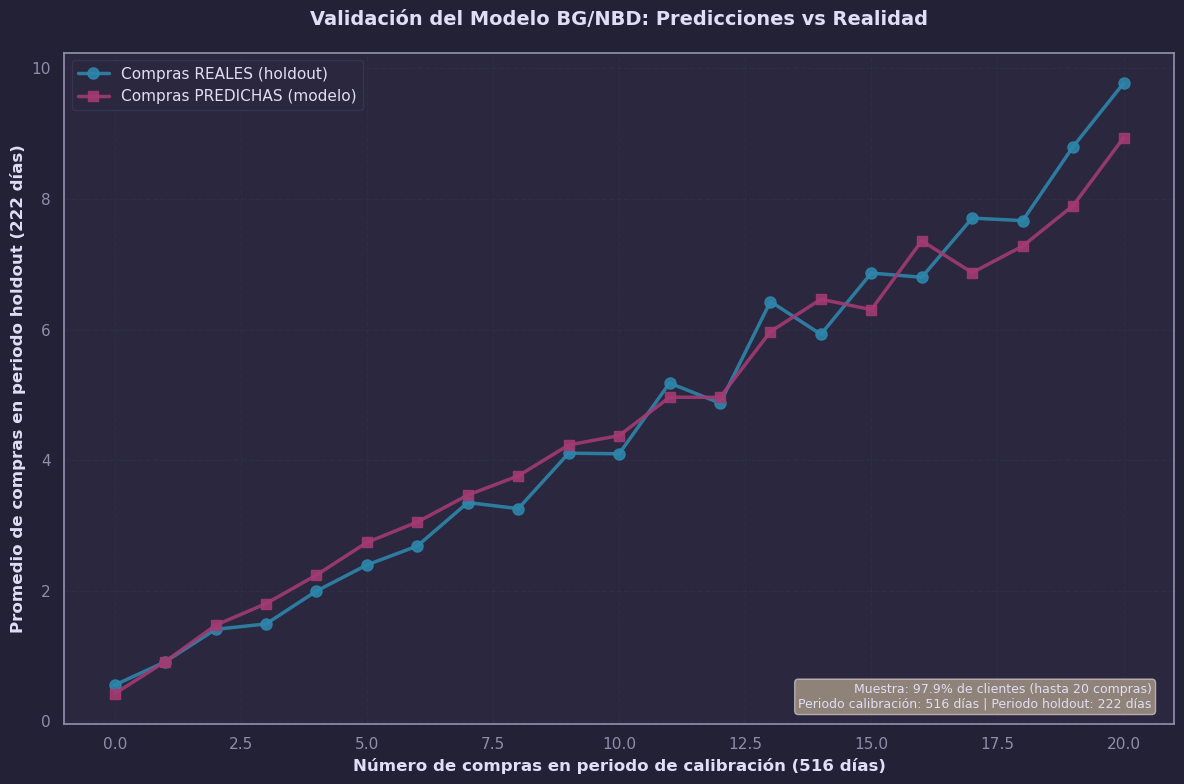

Gráfico guardado: actual_vs_predicted_explained.png


In [77]:
# PASO 1: Agrupar clientes por cuántas compras hicieron en calibración
cal_days = int(df_rftm_cal["T_cal"].max())

grouped = df_rftm_cal.groupby('frequency_cal').agg({
    'frequency_holdout': 'mean',      # Promedio REAL en holdout
    'predicted_purchases': 'mean'     # Promedio PREDICHO
}).reset_index()

print("Ejemplo de agrupación:")
print("  Clientes con 5 compras en calibración:")
print(f"    → Compraron en promedio {grouped[grouped['frequency_cal']==5]['frequency_holdout'].values[0]:.2f} veces en holdout (REAL)")
print(f"    → Modelo predijo {grouped[grouped['frequency_cal']==5]['predicted_purchases'].values[0]:.2f} compras (PREDICHO)")
print()

# PASO 2: Decidir hasta dónde mostrar el gráfico
print("Distribución de clientes por frequency_cal:")
freq_dist = df_rftm_cal['frequency_cal'].value_counts().sort_index()
for i in [0, 5, 10, 15, 20]:
    count = (df_rftm_cal['frequency_cal'] <= i).sum()
    pct = count / len(df_rftm_cal) * 100
    print(f"  ≤{i:2d} compras: {count:4d} clientes ({pct:5.1f}%)")
print()

# Elegir límite (20 captura ~95% de los clientes)
max_freq_show = 20
pct_covered = (df_rftm_cal['frequency_cal'] <= max_freq_show).sum() / len(df_rftm_cal) * 100

print(f"DECISIÓN: Mostrar hasta {max_freq_show} compras")
print(f"  Esto cubre {pct_covered:.1f}% de los clientes")
print(f"  (El resto tiene muy pocos datos para graficar)")
print()

# PASO 3: Crear gráfico
grouped_plot = grouped[grouped['frequency_cal'] <= max_freq_show]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(grouped_plot['frequency_cal'], 
        grouped_plot['frequency_holdout'],
        marker='o', linewidth=2.5, markersize=8,
        color='#2E86AB', label='Compras REALES (holdout)',
        alpha=0.9)

ax.plot(grouped_plot['frequency_cal'], 
        grouped_plot['predicted_purchases'],
        marker='s', linewidth=2.5, markersize=7,
        color='#A23B72', label='Compras PREDICHAS (modelo)',
        alpha=0.9)

ax.set_xlabel(f'Número de compras en periodo de calibración ({cal_days} días)', 
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'Promedio de compras en periodo holdout ({holdout_days} días)', 
              fontsize=12, fontweight='bold')
ax.set_title('Validación del Modelo BG/NBD: Predicciones vs Realidad',
            fontsize=14, fontweight='bold', pad=20)

ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--')

# Añadir anotación explicativa
ax.text(0.98, 0.02, 
        f'Muestra: {pct_covered:.1f}% de clientes (hasta {max_freq_show} compras)\n'
        f'Periodo calibración: {cal_days} días | Periodo holdout: {holdout_days} días',
        transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('_img/actual_vs_predicted_explained.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico guardado: actual_vs_predicted_explained.png")

### **GRÁFICO: FREQUENCY-RECENCY MATRIX (ESTO ES COMPRAS ESPERADAS)**

Para cada combinación de Frequency + Recency, el modelo predice cuántas compras hará el cliente en el siguiente periodo.

In [78]:
df_rftm_cal

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases
Customer ID,,,,,,,,
12346.0,2.0,322.0,425.0,38662.955000,0.0,0.000000,222.0,1.153563
12347.0,3.0,158.0,182.0,607.810000,4.0,25.373163,222.0,3.214848
12348.0,3.0,190.0,216.0,495.746667,1.0,103.333333,222.0,2.826781
12349.0,2.0,182.0,367.0,801.310000,1.0,24.076027,222.0,1.251417
12350.0,0.0,0.0,88.0,0.000000,0.0,0.000000,222.0,NaN
...,...,...,...,...,...,...,...,...
18283.0,8.0,426.0,436.0,119.096250,10.0,3.013489,222.0,3.809616
18284.0,0.0,0.0,209.0,0.000000,0.0,0.000000,222.0,0.507238
18285.0,0.0,0.0,438.0,0.000000,0.0,0.000000,222.0,0.278540


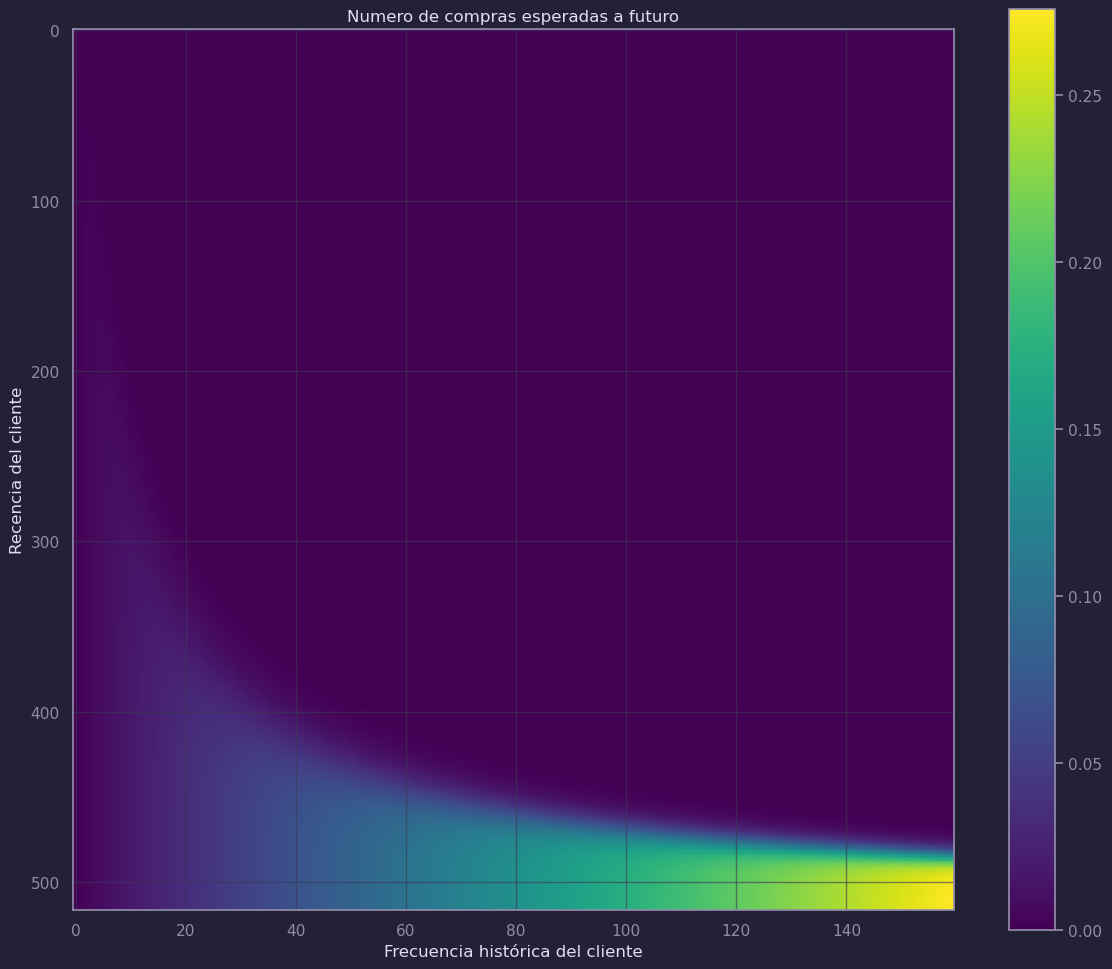

In [79]:
fig = plt.figure(figsize=(12, 10))

plot_frequency_recency_matrix(
    BetaGeo,
    T=1,
    cmap='viridis',
    title='Numero de compras esperadas a futuro',
    xlabel="Frecuencia histórica del cliente",
    ylabel="Recencia del cliente"
)

plt.tight_layout()
plt.savefig('_img/Matrix Compras Esperadas.png', dpi=300, bbox_inches='tight')
plt.show()



### **GRÁFICO: PROBABILIDAD DE QUE UN CLIENTE SIGA VIVO (ACTIVO)**

**Zonas SEGURAS (amarillo, P~1.0):**

- Bottom-left: Clientes ocasionales.
- Es NORMAL que no compren seguido.
- P(alive) = 100%

**Zonas de RIESGO (azul/verde, P~0.4-0.6):**

- Top-right: Clientes frecuentes que dejaron de comprar.
- Alta frecuencia + baja recency = SOSPECHOSO.
- Posible churn en progreso.

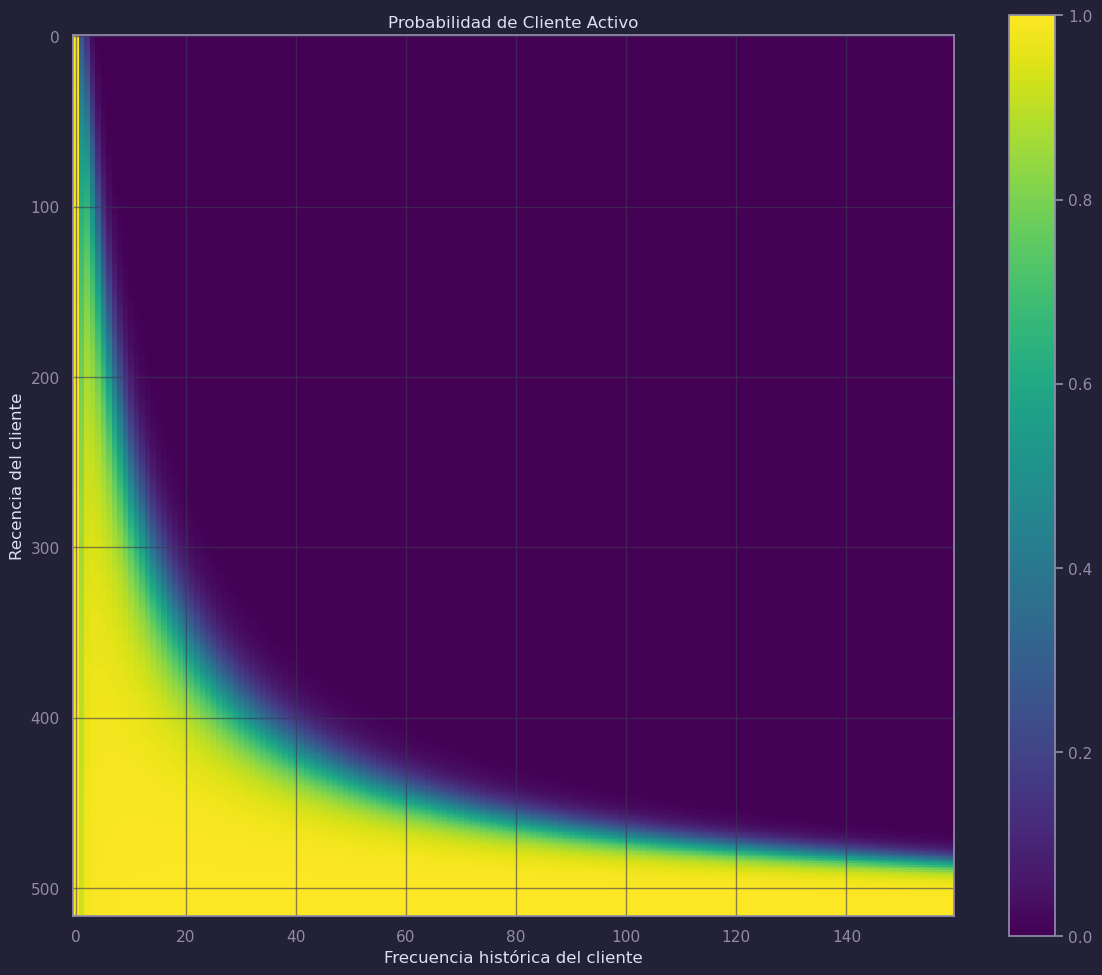

In [80]:
fig = plt.figure(figsize=(12, 10))

plot_probability_alive_matrix(
    BetaGeo,
    cmap='viridis',
    title='Probabilidad de Cliente Activo',
    xlabel="Frecuencia histórica del cliente",
    ylabel="Recencia del cliente"
)

plt.tight_layout()
plt.savefig('_img/Probabilty Customer is Alive.png', dpi=300, bbox_inches='tight')
plt.show()


### **PREDICIENDO EL CUSTOMER LIFETIME VALUE (CLV)**

In [81]:
# Asignar los clusters de KMeans al DataFrame de calibración/holdout (df_rftm_cal)
# df_rftm_cal tiene Customer ID como índice; rfm tiene Customer ID como columna
cluster_map = rfm[["Customer ID", "cluster", "segment"]].copy()
cluster_map["Customer ID"] = cluster_map["Customer ID"].astype(float)
cluster_map = cluster_map.set_index("Customer ID")

df_rftm_cal = df_rftm_cal.join(cluster_map, how="left")

print(f"Clientes con cluster asignado: {df_rftm_cal['cluster'].notna().sum()} / {len(df_rftm_cal)}")
print()
print(df_rftm_cal["segment"].value_counts())

Clientes con cluster asignado: 4822 / 4822

segment
Lost          1645
Potential     1415
Premium       1143
Occasional     619
Name: count, dtype: int64


### **Cálculo de CLV**

In [82]:
from lifetimes import GammaGammaFitter

# Detectar nombre de columna monetary (varía según versión de lifetimes)
mv_col = "monetary_value_cal" if "monetary_value_cal" in df_rftm_cal.columns else "monetary_value"
print(f"Columna monetaria detectada: '{mv_col}'")

Columna monetaria detectada: 'monetary_value_cal'


**Calcular el customer lifetime value**

In [83]:
# PASO 1a: Preparar datos para Gamma-Gamma
returning_customers_cal = df_rftm_cal[df_rftm_cal['frequency_cal'] > 0].copy()

print(f"  Total clientes: {len(df_rftm_cal):,}")
print(f"  Con compras repetidas: {len(returning_customers_cal):,}")

# PASO 1b: Verificar asunción de independencia Frequency-Monetary (requerida por Gamma-Gamma)
corr = returning_customers_cal[['frequency_cal', mv_col]].corr().iloc[0,1]
print(f"  Correlación Frequency-Monetary: {corr:.4f}")
if abs(corr) < 0.3:
    print("  -> Correlación baja: asunción de independencia se cumple razonablemente.")
else:
    print("  -> ADVERTENCIA: Correlación moderada/alta. Los resultados de Gamma-Gamma deben interpretarse con cautela.")
print()

  Total clientes: 4,822
  Con compras repetidas: 3,192
  Correlación Frequency-Monetary: 0.0819
  -> Correlación baja: asunción de independencia se cumple razonablemente.



**Asunción de independencia Frequency-Monetary**

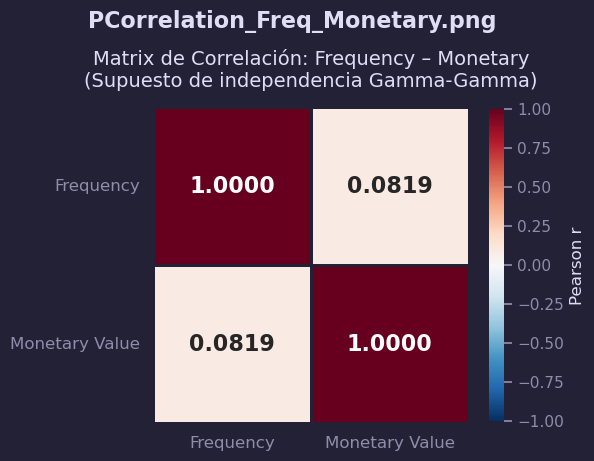


Pearson r = 0.0819
✓ Correlación Baja – El supuesto de independencia se cumple razonablemente.


In [84]:
# Correlation Matrix: Frequency vs Monetary (independencia requerida por Gamma-Gamma)
corr_matrix = returning_customers_cal[['frequency_cal', mv_col]].corr()

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".4f",
    cmap="RdBu_r",
    center=0,
    vmin=-1, vmax=1,
    square=True,
    linewidths=1,
    linecolor="#232136",
    annot_kws={"size": 16, "weight": "bold"},
    cbar_kws={"shrink": 0.8, "label": "Pearson r"},
    ax=ax
)
ax.set_xticklabels(["Frequency", "Monetary Value"], fontsize=12)
ax.set_yticklabels(["Frequency", "Monetary Value"], fontsize=12, rotation=0)
ax.set_title("Matrix de Correlación: Frequency – Monetary\n(Supuesto de independencia Gamma-Gamma)",
             fontsize=14, pad=15)
plt.tight_layout()
plt.suptitle('PCorrelation_Freq_Monetary.png', fontsize=16, fontweight='bold')
plt.savefig("_img/Correlation_Freq_Monetary.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nPearson r = {corr_matrix.iloc[0,1]:.4f}")
if abs(corr_matrix.iloc[0,1]) < 0.3:
    print("✓ Correlación Baja – El supuesto de independencia se cumple razonablemente.")
else:
    print("⚠ Moderada/Alta Correlación – Los resultados de Gamma-Gamma deben interpretarse con precaución.")

**Entrenamiento de Gamma-Gamma**

In [85]:
# PASO 2: Entrenar Gamma-Gamma
print("PASO 2: Entrenando modelo Gamma-Gamma...")
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(
    returning_customers_cal['frequency_cal'],
    returning_customers_cal[mv_col]
)
print("  Modelo entrenado")
print()

PASO 2: Entrenando modelo Gamma-Gamma...
  Modelo entrenado



In [86]:
# ─── Exportar modelo Gamma-Gamma (joblib, compatible con Streamlit Cloud) ───
ggf_attrs = {
    "params_": ggf.params_,
    "penalizer_coef": ggf.penalizer_coef,
    "data": ggf.data,
    "_hessian_": ggf._hessian_,
    "variance_matrix_": ggf.variance_matrix_,
    "standard_errors_": ggf.standard_errors_,
    "confidence_intervals_": ggf.confidence_intervals_,
    "_negative_log_likelihood_": ggf._negative_log_likelihood_,
}
joblib.dump(ggf_attrs, '_models/ggf_model.pkl')

print("✓ Gamma-Gamma guardado en _models/ggf_model.pkl (joblib)")

✓ Gamma-Gamma guardado en _models/ggf_model.pkl (joblib)


In [87]:
ggf.params_

p      2.322840
q      3.467598
v    434.688407
dtype: float64

# **7 ESTIMACIÓN DEL CLV**

**Calcular CLV a 12 meses**

In [88]:
# PASO 3: Calcular CLV
print("PASO 3: Calculando CLV...")
time_horizon = 12  # meses
monthly_discount_rate = 0.01  # 1%

returning_customers_cal['clv'] = ggf.customer_lifetime_value(
    BetaGeo,
    returning_customers_cal['frequency_cal'],
    returning_customers_cal['recency_cal'],
    returning_customers_cal['T_cal'],
    returning_customers_cal[mv_col],
    time=time_horizon,
    discount_rate=monthly_discount_rate
)

# Asignar CLV a todos
df_rftm_cal['clv'] = 0.0
df_rftm_cal.loc[df_rftm_cal['frequency_cal'] > 0, 'clv'] = returning_customers_cal['clv'].values

print(f"  CLV total: £{df_rftm_cal['clv'].sum():,.2f}")
print(f"  CLV promedio: £{df_rftm_cal['clv'].mean():,.2f}")
print()

PASO 3: Calculando CLV...
  CLV total: £6,485,442.00
  CLV promedio: £1,344.97



**Análisis por cluster**

In [89]:
cluster_analysis = df_rftm_cal.groupby('cluster').agg({
    'clv': ['mean', 'median', 'sum', 'count'],
    'frequency_cal': 'mean',
    'recency_cal': 'mean',
    'T_cal': 'mean',
    mv_col: 'mean',
}).round(2)

cluster_analysis.columns = ['_'.join(col) for col in cluster_analysis.columns]
cluster_analysis = cluster_analysis.rename(columns={
    'clv_mean': 'CLV_promedio',
    'clv_median': 'CLV_mediana',
    'clv_sum': 'CLV_total',
    'clv_count': 'N_clientes',
    'frequency_cal_mean': 'Freq_promedio',
    'recency_cal_mean': 'Recency_promedio',
    'T_cal_mean': 'T_promedio',
    f'{mv_col}_mean': 'Valor_promedio'
})

cluster_analysis = cluster_analysis.sort_index()

print(cluster_analysis[[
    'N_clientes', 'CLV_promedio', 'CLV_total', 
    'Freq_promedio', 'Valor_promedio'
]].to_string())
print()

# Etiquetar clusters usando los nombres dinámicos
cluster_labels = {k: f"Cluster {k}: {v}" for k, v in cluster_names.items()}

         N_clientes  CLV_promedio   CLV_total  Freq_promedio  Valor_promedio
cluster                                                                     
0               619        325.07   201216.04           0.94          129.21
1              1645        103.14   169658.65           0.31           51.09
2              1143       4205.99  4807445.14          10.27          523.15
3              1415        923.76  1307122.17           2.87          400.90



**Interpretación**

In [90]:
total_clv = df_rftm_cal['clv'].sum()
total_clientes = len(df_rftm_cal)

for cluster_id in sorted(cluster_names.keys()):
    if cluster_id in cluster_analysis.index:
        row = cluster_analysis.loc[cluster_id]
        
        print(f"  {cluster_labels[cluster_id]}")
        print(f"  N Clientes: {int(row['N_clientes']):,} ({int(row['N_clientes'])/total_clientes*100:.1f}%)")
        print(f"  CLV promedio: £{row['CLV_promedio']:,.2f}")
        print(f"  CLV total: £{row['CLV_total']:,.2f}")
        print()

# Concentración
print("=" * 80)
print("CONCENTRACIÓN DE CLV:")
print("-" * 80)
print()

for cluster_id in sorted(cluster_names.keys()):
    if cluster_id in cluster_analysis.index:
        pct_clientes = cluster_analysis.loc[cluster_id, 'N_clientes'] / total_clientes * 100
        pct_clv = cluster_analysis.loc[cluster_id, 'CLV_total'] / total_clv * 100
        ratio = pct_clv / pct_clientes if pct_clientes > 0 else 0
        
        print(f"  {cluster_labels[cluster_id]}: {pct_clientes:5.1f}% clientes -> {pct_clv:5.1f}% CLV (ratio: {ratio:.2f}x)")

print()

  Cluster 0: Occasional
  N Clientes: 619 (12.8%)
  CLV promedio: £325.07
  CLV total: £201,216.04

  Cluster 1: Lost
  N Clientes: 1,645 (34.1%)
  CLV promedio: £103.14
  CLV total: £169,658.65

  Cluster 2: Premium
  N Clientes: 1,143 (23.7%)
  CLV promedio: £4,205.99
  CLV total: £4,807,445.14

  Cluster 3: Potential
  N Clientes: 1,415 (29.3%)
  CLV promedio: £923.76
  CLV total: £1,307,122.17

CONCENTRACIÓN DE CLV:
--------------------------------------------------------------------------------

  Cluster 0: Occasional:  12.8% clientes ->   3.1% CLV (ratio: 0.24x)
  Cluster 1: Lost:  34.1% clientes ->   2.6% CLV (ratio: 0.08x)
  Cluster 2: Premium:  23.7% clientes ->  74.1% CLV (ratio: 3.13x)
  Cluster 3: Potential:  29.3% clientes ->  20.2% CLV (ratio: 0.69x)



#### **Distribución del CLV**

La distribución del CLV presenta una fuerte asimetría positiva, característica habitual en contextos de comercio electrónico. La mayoría de los clientes genera un CLV relativamente bajo, mientras que un reducido grupo de clientes de alto valor concentra una proporción desproporcionada del valor total. Esta asimetría se evidencia en la diferencia entre la media y la mediana: la media es significativamente superior, lo que confirma la influencia de los clientes Premium en el valor agregado.

Para facilitar la interpretación visual, se presenta la distribución tanto en escala logarítmica (que permite apreciar la amplitud completa de los valores) como recortada al percentil 95 (que muestra con mayor detalle la zona donde se concentra el grueso de los clientes).

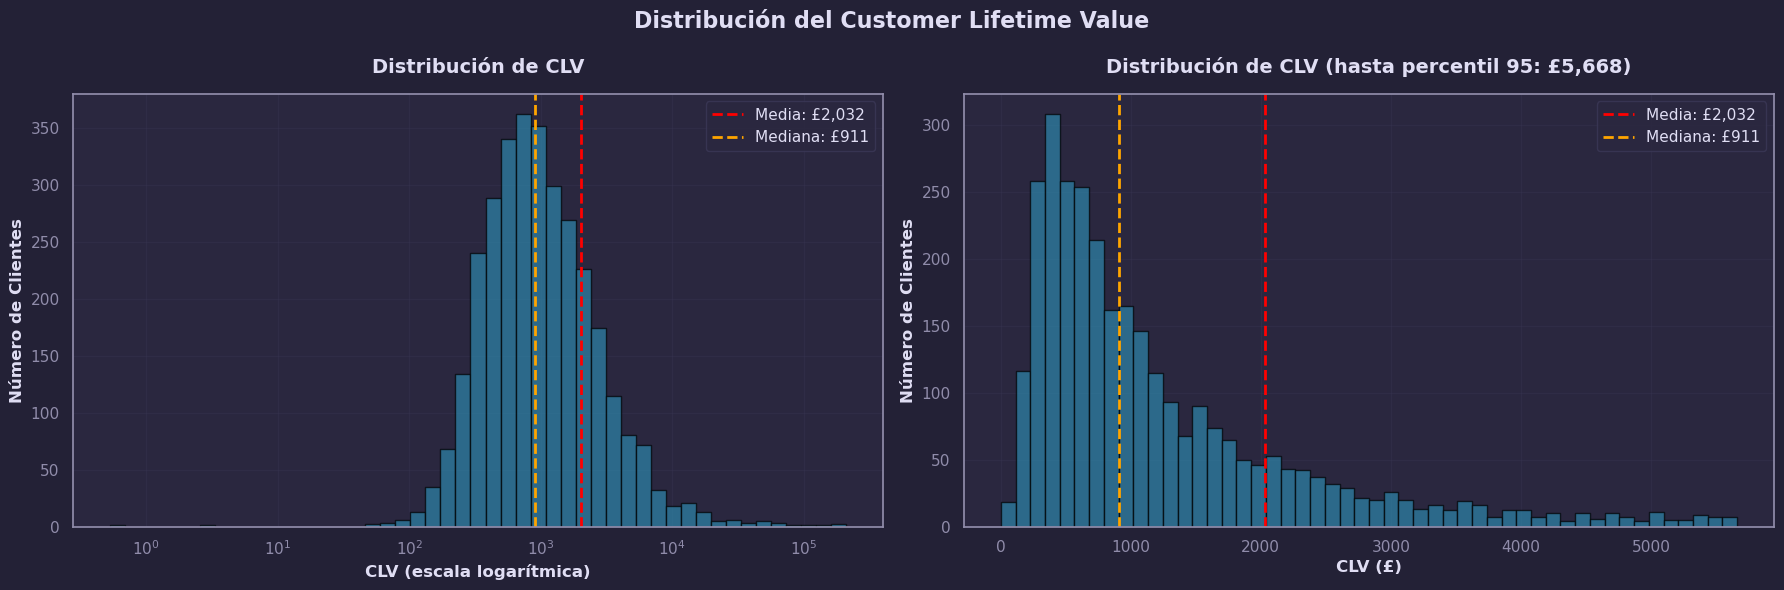

  CLV_Distribution.png



In [91]:
# Colores por cluster (consistentes en todos los gráficos)
cluster_colors = {0: '#FFD700', 1: '#FF6B6B', 2: '#4ECDC4', 3: '#95E1D3'}

# --- PANEL 1: Distribución de CLV (histograma con escala log en X) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

clv_positive = df_rftm_cal[df_rftm_cal['clv'] > 0]['clv']

# 1a: Histograma en escala logarítmica
ax1 = axes[0]
ax1.hist(clv_positive, bins=np.logspace(np.log10(clv_positive.min()), np.log10(clv_positive.max()), 50),
         color='#2E86AB', edgecolor='black', alpha=0.7)
ax1.set_xscale('log')
ax1.set_xlabel('CLV (escala logarítmica)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Número de Clientes', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de CLV', fontsize=14, fontweight='bold', pad=15)

mean_clv = clv_positive.mean()
median_clv = clv_positive.median()
ax1.axvline(mean_clv, color='red', linestyle='--', linewidth=2, label=f'Media: £{mean_clv:,.0f}')
ax1.axvline(median_clv, color='orange', linestyle='--', linewidth=2, label=f'Mediana: £{median_clv:,.0f}')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# 1b: Histograma recortado al percentil 95 (vista detallada)
ax2 = axes[1]
p95 = clv_positive.quantile(0.95)
clv_clipped = clv_positive[clv_positive <= p95]
ax2.hist(clv_clipped, bins=50, color='#2E86AB', edgecolor='black', alpha=0.7)
ax2.set_xlabel('CLV (£)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Número de Clientes', fontsize=12, fontweight='bold')
ax2.set_title(f'Distribución de CLV (hasta percentil 95: £{p95:,.0f})', fontsize=14, fontweight='bold', pad=15)
ax2.axvline(mean_clv, color='red', linestyle='--', linewidth=2, label=f'Media: £{mean_clv:,.0f}')
ax2.axvline(median_clv, color='orange', linestyle='--', linewidth=2, label=f'Mediana: £{median_clv:,.0f}')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.suptitle("Distribución del Customer Lifetime Value", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('_img/CLV_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("  CLV_Distribution.png")
print()

#### **CLV por segmento**

El análisis por segmentos revela diferencias marcadas entre los cuatro clusters identificados mediante K-Means:

- **Clientes Premium**: Presentan el CLV promedio más elevado, lo que confirma su papel como núcleo económico del negocio. Pese a representar una fracción minoritaria de la base de clientes, concentran la mayor parte del valor total.

- **Clientes Potenciales**: Muestran un CLV intermedio. Aunque su recency es elevada (no compran recientemente), su historial de compras sugiere que una estrategia de reactivación podría recuperar parte de su valor latente.

- **Clientes Ocasionales**: Presentan un CLV bajo-medio, coherente con su comportamiento esporádico. Representan una oportunidad de crecimiento si se logra incrementar su frecuencia de compra.

- **Clientes Perdidos (Lost)**: Registran el CLV más bajo, lo cual es consistente con su alta recency y mínima frecuencia. El coste de reactivación de este segmento debe evaluarse frente al retorno esperado.

C:\Users\BRCK\AppData\Local\Temp\ipykernel_26896\1004748480.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_by_cluster,


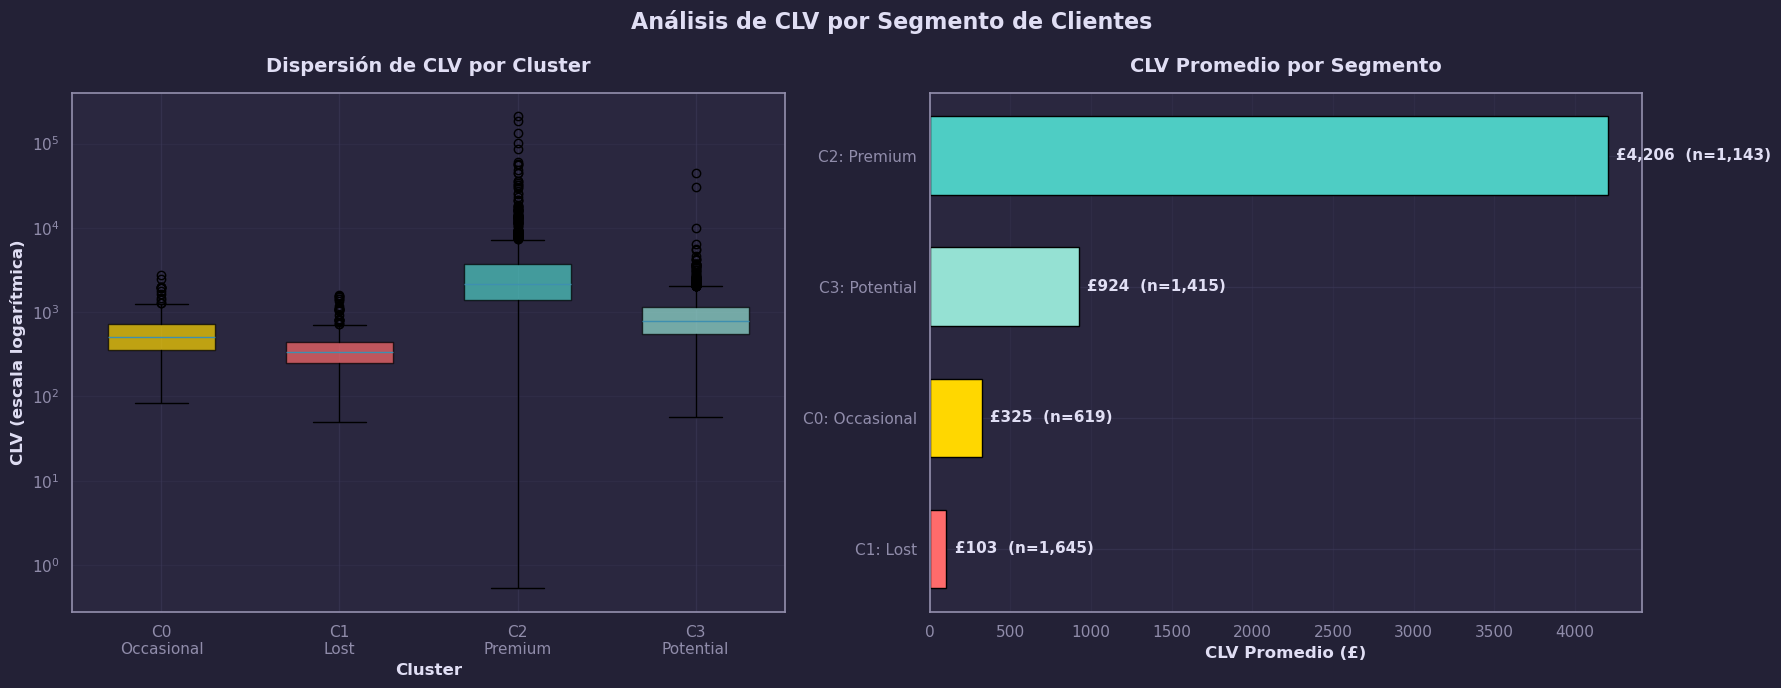

  CLV_by_Cluster.png



In [92]:
# --- PANEL 2: CLV por Cluster (boxplot + barras) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 2a: Boxplot con escala log (muestra la dispersión real)
ax3 = axes[0]
df_box = df_rftm_cal[df_rftm_cal['clv'] > 0].copy()
cluster_ids = sorted(df_box['cluster'].dropna().unique().astype(int))
data_by_cluster = [df_box[df_box['cluster'] == c]['clv'].values for c in cluster_ids]

bp = ax3.boxplot(data_by_cluster, 
                 labels=[f"C{c}\n{cluster_names.get(c, '')}" for c in cluster_ids], 
                 patch_artist=True, widths=0.6)

for i, (patch, cid) in enumerate(zip(bp['boxes'], cluster_ids)):
    patch.set_facecolor(cluster_colors.get(cid, '#999999'))
    patch.set_alpha(0.7)

ax3.set_yscale('log')
ax3.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax3.set_ylabel('CLV (escala logarítmica)', fontsize=12, fontweight='bold')
ax3.set_title('Dispersión de CLV por Cluster', fontsize=14, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3)

# 2b: Barras horizontales con CLV promedio
ax4 = axes[1]
cluster_means_sorted = cluster_analysis['CLV_promedio'].sort_values(ascending=True)
bar_colors = [cluster_colors.get(int(i), '#999999') for i in cluster_means_sorted.index]

bars = ax4.barh(
    [f"C{int(i)}: {cluster_names.get(int(i), '')}" for i in cluster_means_sorted.index],
    cluster_means_sorted.values,
    color=bar_colors, edgecolor='black', height=0.6
)

for i, (idx, v) in enumerate(cluster_means_sorted.items()):
    n = int(cluster_analysis.loc[idx, 'N_clientes'])
    ax4.text(v + 50, i, f'£{v:,.0f}  (n={n:,})', va='center', fontsize=11, fontweight='bold')

ax4.set_xlabel('CLV Promedio (£)', fontsize=12, fontweight='bold')
ax4.set_title('CLV Promedio por Segmento', fontsize=14, fontweight='bold', pad=15)
ax4.grid(axis='x', alpha=0.3)

plt.suptitle("Análisis de CLV por Segmento de Clientes", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('_img/CLV_by_Cluster.png', dpi=300, bbox_inches='tight')
plt.show()
print("  CLV_by_Cluster.png")
print()

#### **Relación CLV vs Valor Monetario**

El gráfico de dispersión confirma una relación positiva entre el valor monetario promedio por transacción y el CLV, lo cual es esperable dado que el modelo Gamma-Gamma utiliza directamente esta variable en su estimación. Sin embargo, se observa que el CLV no depende únicamente del valor monetario: clientes con valores monetarios similares pueden tener CLV significativamente diferentes en función de su frecuencia de compra y su probabilidad de seguir activos (P(alive)).


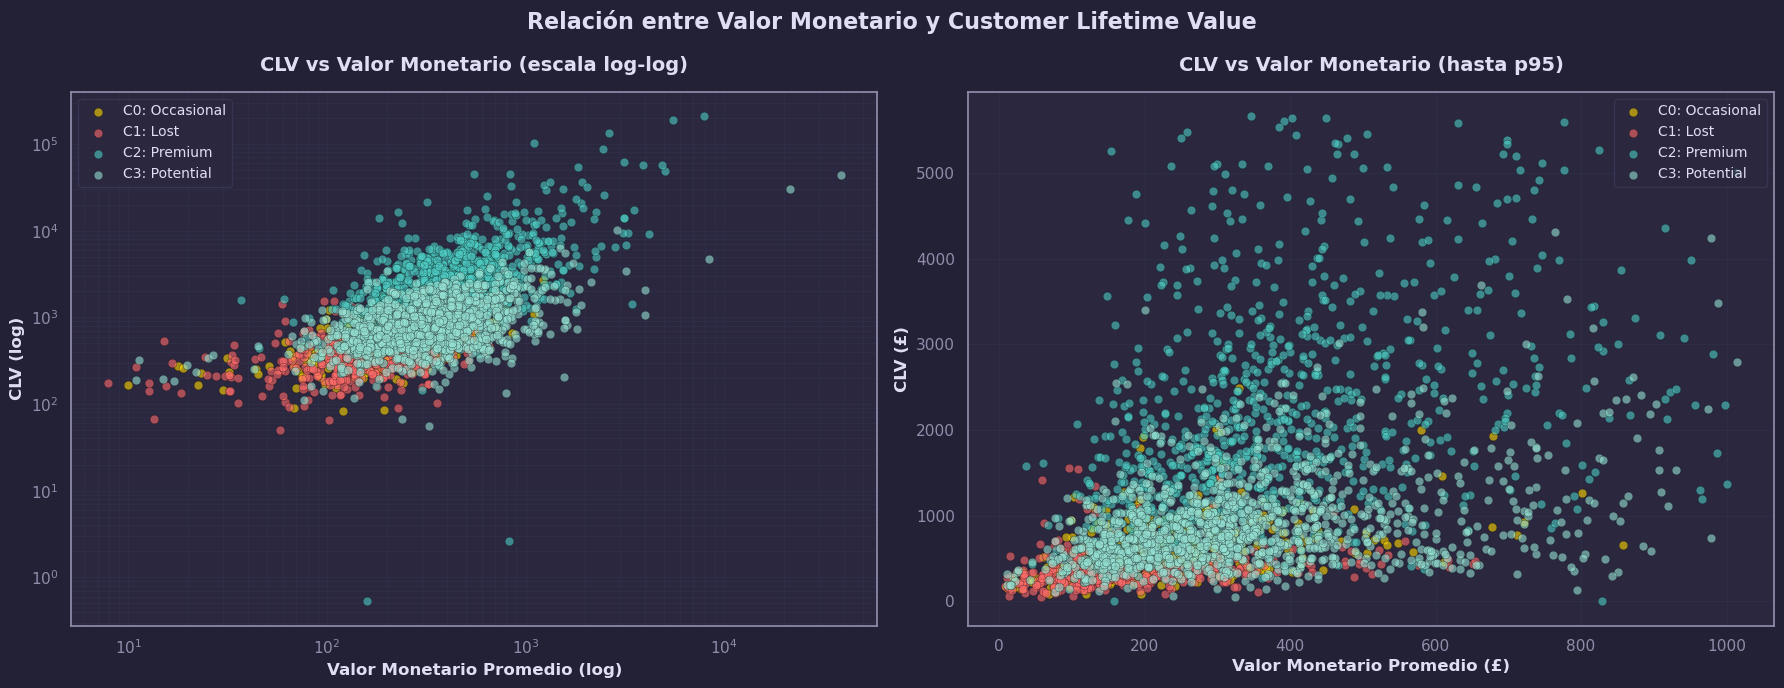

  CLV_vs_Monetary.png



In [93]:
# --- PANEL 3: Scatter CLV vs Monetary (con escala log) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

df_scatter = df_rftm_cal[df_rftm_cal['clv'] > 0].copy()

# 3a: Scatter completo en escala log-log
ax5 = axes[0]
for cid in sorted(df_scatter['cluster'].dropna().unique().astype(int)):
    data = df_scatter[df_scatter['cluster'] == cid]
    ax5.scatter(data[mv_col], data['clv'], 
                c=cluster_colors.get(cid, '#999999'),
                alpha=0.6, s=40, label=f'C{cid}: {cluster_names.get(cid, "")}',
                edgecolors='black', linewidth=0.3)

ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel('Valor Monetario Promedio (log)', fontsize=12, fontweight='bold')
ax5.set_ylabel('CLV (log)', fontsize=12, fontweight='bold')
ax5.set_title('CLV vs Valor Monetario (escala log-log)', fontsize=14, fontweight='bold', pad=15)
ax5.legend(fontsize=10)
ax5.grid(alpha=0.3, which='both')

# 3b: Scatter recortado (percentil 95) para vista detallada
ax6 = axes[1]
p95_mv = df_scatter[mv_col].quantile(0.95)
p95_clv = df_scatter['clv'].quantile(0.95)
df_detail = df_scatter[(df_scatter[mv_col] <= p95_mv) & (df_scatter['clv'] <= p95_clv)]

for cid in sorted(df_detail['cluster'].dropna().unique().astype(int)):
    data = df_detail[df_detail['cluster'] == cid]
    ax6.scatter(data[mv_col], data['clv'],
                c=cluster_colors.get(cid, '#999999'),
                alpha=0.6, s=40, label=f'C{cid}: {cluster_names.get(cid, "")}',
                edgecolors='black', linewidth=0.3)

ax6.set_xlabel('Valor Monetario Promedio (£)', fontsize=12, fontweight='bold')
ax6.set_ylabel('CLV (£)', fontsize=12, fontweight='bold')
ax6.set_title(f'CLV vs Valor Monetario (hasta p95)', fontsize=14, fontweight='bold', pad=15)
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)

plt.suptitle("Relación entre Valor Monetario y Customer Lifetime Value", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('_img/CLV_vs_Monetary.png', dpi=300, bbox_inches='tight')
plt.show()
print("  CLV_vs_Monetary.png")
print()

#### **Análisis de Pareto (Concentración del CLV)**

El análisis de Pareto revela que aproximadamente el 36% de los clientes concentra el 80% del CLV total. Este resultado se aproxima al principio de Pareto clásico (80/20) pero con una distribución ligeramente menos concentrada, lo que indica que la base de clientes activos tiene un valor más distribuido que en otros contextos de negocio.

Esta concentración tiene implicaciones directas para la estrategia comercial: los recursos de retención y fidelización deben priorizarse en los segmentos Premium y Potencial, que representan la mayor proporción del valor futuro esperado. Invertir de forma indiscriminada en toda la base de clientes sería ineficiente desde una perspectiva de retorno sobre la inversión.

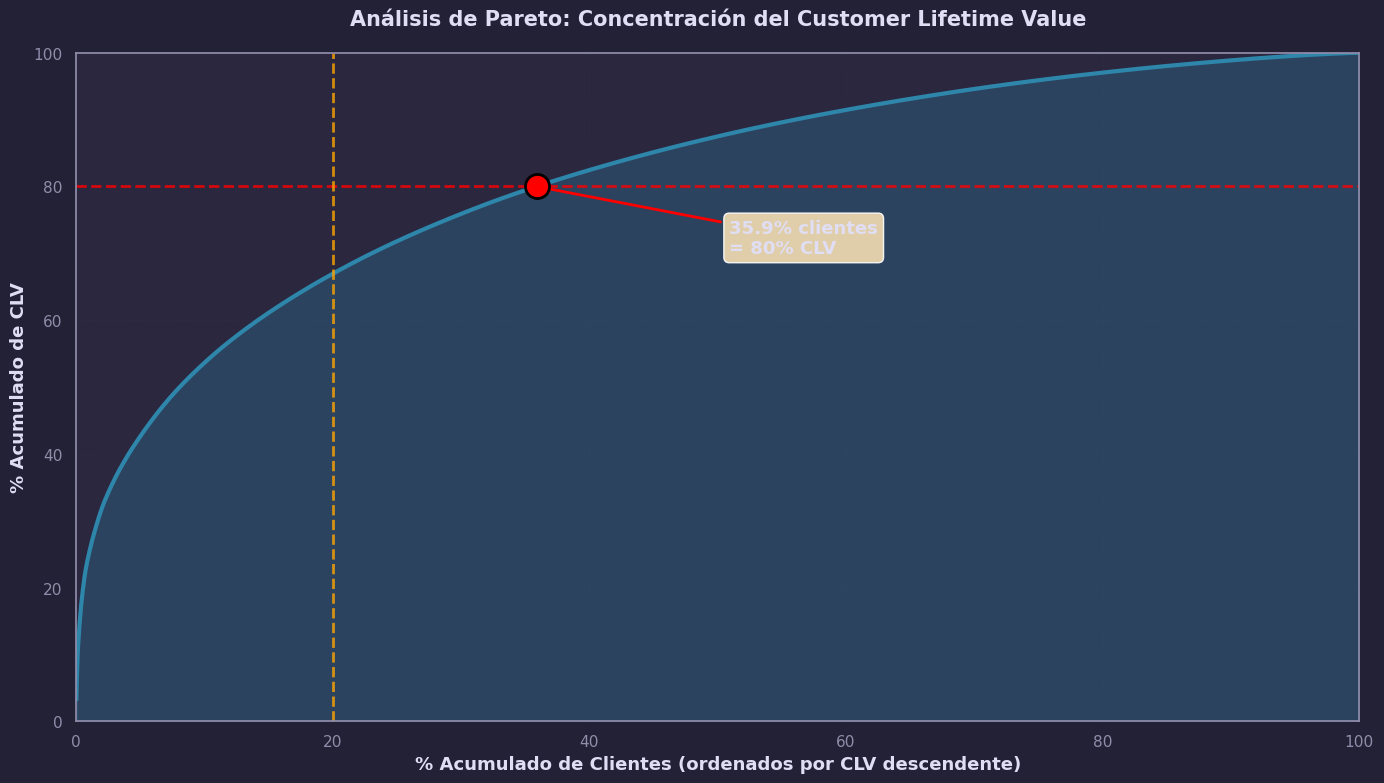

  CLV_Pareto_Analysis.png



In [94]:
# --- PANEL 4: Pareto ---
fig, ax = plt.subplots(figsize=(14, 8))

df_sorted = df_rftm_cal[df_rftm_cal['clv'] > 0].sort_values('clv', ascending=False).reset_index(drop=True)
df_sorted['clv_cumsum'] = df_sorted['clv'].cumsum()
df_sorted['clv_cumsum_pct'] = df_sorted['clv_cumsum'] / df_sorted['clv'].sum() * 100
df_sorted['customer_pct'] = (df_sorted.index + 1) / len(df_sorted) * 100

ax.plot(df_sorted['customer_pct'], df_sorted['clv_cumsum_pct'], linewidth=3, color='#2E86AB')
ax.fill_between(df_sorted['customer_pct'], df_sorted['clv_cumsum_pct'], alpha=0.3, color='#2E86AB')

ax.axhline(y=80, color='red', linestyle='--', linewidth=2, alpha=0.8)
ax.axvline(x=20, color='orange', linestyle='--', linewidth=2, alpha=0.8)

idx_80 = (df_sorted['clv_cumsum_pct'] >= 80).idxmax()
pct_customers_80 = df_sorted.loc[idx_80, 'customer_pct']

ax.scatter([pct_customers_80], [80], color='red', s=300, zorder=5, edgecolor='black', linewidth=2)
ax.annotate(f'{pct_customers_80:.1f}% clientes\n= 80% CLV',
            xy=(pct_customers_80, 80), xytext=(pct_customers_80 + 15, 70),
            fontsize=13, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9),
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))

ax.set_xlabel('% Acumulado de Clientes (ordenados por CLV descendente)', fontsize=13, fontweight='bold')
ax.set_ylabel('% Acumulado de CLV', fontsize=13, fontweight='bold')
ax.set_title('Análisis de Pareto: Concentración del Customer Lifetime Value', fontsize=15, fontweight='bold', pad=20)
ax.grid(alpha=0.3, linestyle=':')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('_img/CLV_Pareto_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("  CLV_Pareto_Analysis.png")
print()

**Exportar Resultados**

In [95]:
df_rftm_cal['cluster_label'] = df_rftm_cal['cluster'].map(cluster_labels)

df_rftm_cal[['frequency_cal', 'recency_cal', mv_col, 'clv', 'cluster', 'cluster_label']].to_csv('_csv/CLV_by_Customer.csv')
print("  CLV_by_Customer.csv")

cluster_analysis['cluster_label'] = cluster_analysis.index.map(cluster_labels)
cluster_analysis.to_csv('_csv/CLV_by_Cluster_Summary.csv')
print("  CLV_by_Cluster_Summary.csv")

df_rftm_cal.nlargest(100, 'clv')[['clv', 'cluster', 'cluster_label']].to_csv('_csv/Top_100_CLV.csv')
print("  Top_100_CLV.csv")

  CLV_by_Customer.csv
  CLV_by_Cluster_Summary.csv
  Top_100_CLV.csv


### **Interpretación de los resultados del Customer Lifetime Value (CLV)**

El Customer Lifetime Value (CLV) representa el valor económico total que se espera que un cliente genere para la empresa durante un horizonte temporal definido. En este estudio, se ha calculado el CLV a 12 meses con una tasa de descuento mensual del 1%, combinando el modelo BG/NBD (que predice la frecuencia de compras futuras y la probabilidad de que el cliente siga activo) con el modelo Gamma-Gamma (que estima el valor monetario promedio por transacción).


# **8. Modelización Probabilística del Riesgo de Abandono y validación de segmentación**

En la sección anterior, el clustering RFM permitió identificar perfiles estructurales de clientes, entre ellos un segmento denominado "Lost" que agrupa a clientes con alta recencia y baja frecuencia. Sin embargo, esta clasificación es **descriptiva y discreta**: asigna etiquetas basadas en la estructura de los datos, pero no cuantifica el riesgo individual de abandono.

El modelo BG/NBD ofrece una herramienta complementaria: la **probabilidad de que un cliente siga activo, P(alive)**, estimada de forma individual a partir de su historial transaccional. Este enfoque aporta tres ventajas sobre la segmentación por clustering:

1. **Granularidad continua**: en lugar de clasificar a un cliente como "Lost" o "Occasional", P(alive) proporciona un valor entre 0 y 1 que refleja su nivel específico de riesgo.
2. **Fundamento estadístico**: la estimación se basa en un modelo probabilístico bayesiano (BG/NBD), no en reglas heurísticas.
3. **Validación cruzada**: al comparar P(alive) con los segmentos RFM, podemos verificar si ambos enfoques —uno descriptivo y otro predictivo— son coherentes entre sí.

En esta sección se calcula P(alive) para cada cliente, se define un umbral operativo de churn, y se analiza la coherencia entre la clasificación probabilística y la segmentación previa.

In [96]:
# Calcular P(alive) individual para cada cliente usando BG/NBD
df_rftm_cal['p_alive'] = BetaGeo.conditional_probability_alive(
    df_rftm_cal['frequency_cal'],
    df_rftm_cal['recency_cal'],
    df_rftm_cal['T_cal']
)

print(f"P(alive) calculada para {len(df_rftm_cal):,} clientes")
print(f"  Media:   {df_rftm_cal['p_alive'].mean():.4f}")
print(f"  Mediana: {df_rftm_cal['p_alive'].median():.4f}")
print(f"  Min:     {df_rftm_cal['p_alive'].min():.4f}")
print(f"  Max:     {df_rftm_cal['p_alive'].max():.4f}")
print(f"  Std:     {df_rftm_cal['p_alive'].std():.4f}")
print()

# Distribución por quintiles
print("Distribución por quintiles:")
for q in [0.10, 0.25, 0.50, 0.75, 0.90]:
    print(f"  P{int(q*100):3d}: {df_rftm_cal['p_alive'].quantile(q):.4f}")

P(alive) calculada para 4,822 clientes
  Media:   0.9342
  Mediana: 0.9891
  Min:     0.0001
  Max:     1.0000
  Std:     0.1217

Distribución por quintiles:
  P 10: 0.7843
  P 25: 0.9228
  P 50: 0.9891
  P 75: 1.0000
  P 90: 1.0000


**Análisis de distribución P(ALIVE)**

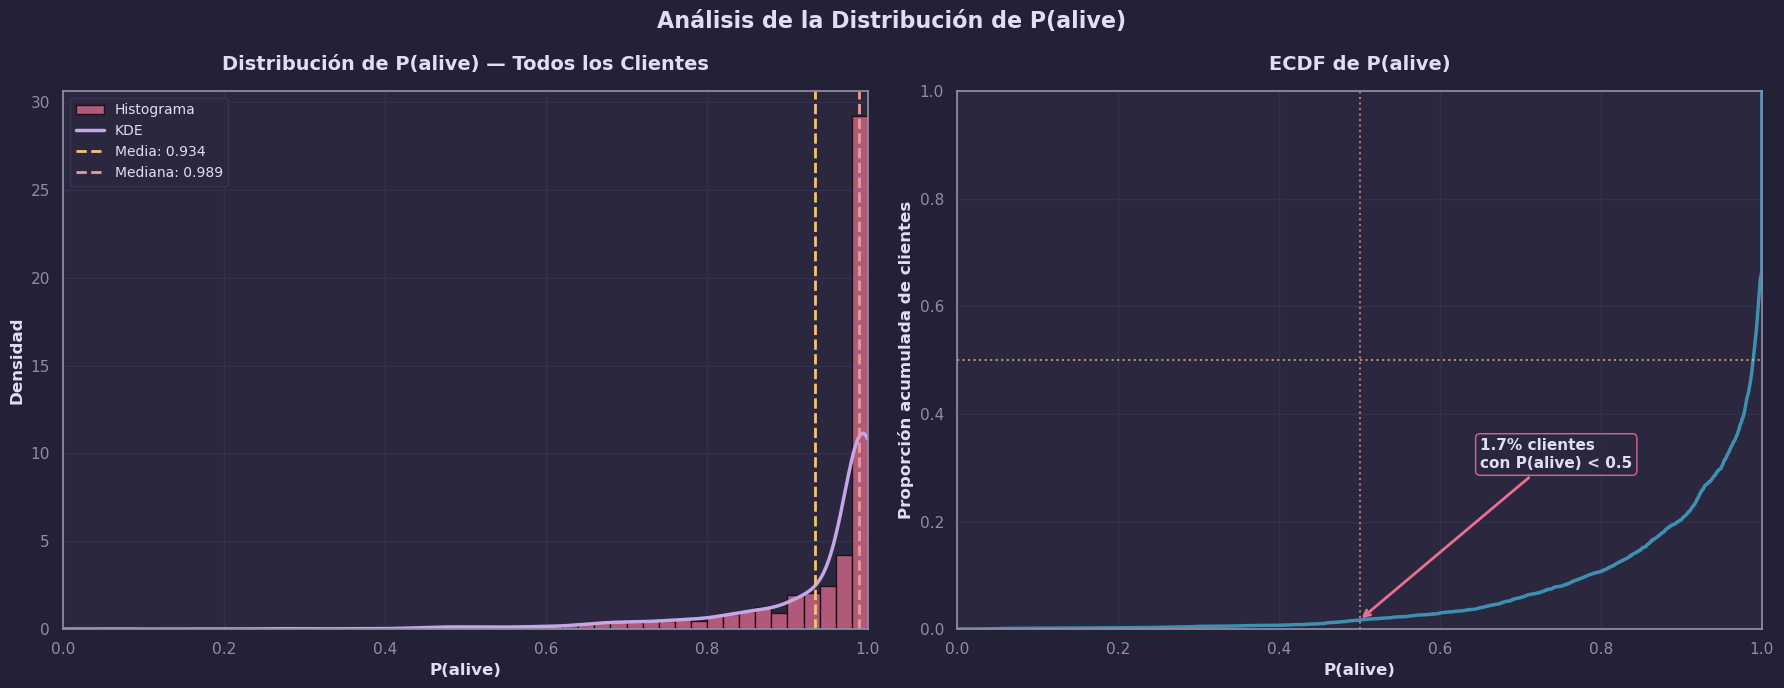

  P_alive_Distribution.png


In [97]:
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ── Panel 1: Histograma + KDE ──
ax1 = axes[0]
ax1.hist(df_rftm_cal['p_alive'], bins=50, color=palette[0], edgecolor='black',
         alpha=0.7, density=True, label='Histograma')

kde_x = np.linspace(0, 1, 500)
kde = gaussian_kde(df_rftm_cal['p_alive'].dropna())
ax1.plot(kde_x, kde(kde_x), color=palette[3], linewidth=2.5, label='KDE')

mean_pa  = df_rftm_cal['p_alive'].mean()
median_pa = df_rftm_cal['p_alive'].median()
ax1.axvline(mean_pa,   color=palette[4], linestyle='--', linewidth=2, label=f'Media: {mean_pa:.3f}')
ax1.axvline(median_pa, color=palette[5], linestyle='--', linewidth=2, label=f'Mediana: {median_pa:.3f}')

ax1.set_xlabel('P(alive)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de P(alive) — Todos los Clientes', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10)
ax1.set_xlim(0, 1)

# ── Panel 2: ECDF ──
ax2 = axes[1]
sorted_pa = np.sort(df_rftm_cal['p_alive'].dropna())
ecdf_y = np.arange(1, len(sorted_pa) + 1) / len(sorted_pa)
ax2.plot(sorted_pa, ecdf_y, color=palette[1], linewidth=2.5)
ax2.axhline(y=0.5, color=palette[4], linestyle=':', alpha=0.7, linewidth=1.5)
ax2.axvline(x=0.5, color=palette[5], linestyle=':', alpha=0.7, linewidth=1.5)

pct_below_05 = (df_rftm_cal['p_alive'] < 0.5).mean() * 100
ax2.annotate(f'{pct_below_05:.1f}% clientes\ncon P(alive) < 0.5',
             xy=(0.5, pct_below_05/100), xytext=(0.65, 0.3),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='#2a273f', edgecolor=palette[0], alpha=0.9),
             arrowprops=dict(arrowstyle='->', lw=2, color=palette[0]))

ax2.set_xlabel('P(alive)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Proporción acumulada de clientes', fontsize=12, fontweight='bold')
ax2.set_title('ECDF de P(alive)', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.suptitle('Análisis de la Distribución de P(alive)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('_img/P_alive_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("  P_alive_Distribution.png")

**Selección del umbral de riesgo**

ANÁLISIS DE SENSIBILIDAD DEL UMBRAL DE CHURN
  Umbral |  Churn (%) |  Activos (%) |  CLV medio churned |  CLV medio activo
-------------------------------------------------------------------------------------
     0.1 |       0.2% |        99.8% | £           97.36 | £       1,347.04
     0.2 |       0.3% |        99.7% | £          231.20 | £       1,347.98
     0.3 |       0.5% |        99.5% | £          412.78 | £       1,349.83
     0.4 |       0.7% |        99.3% | £          342.07 | £       1,352.30
     0.5 |       1.7% |        98.3% | £          677.33 | £       1,356.52
     0.6 |       3.0% |        97.0% | £          555.35 | £       1,369.28
     0.7 |       5.8% |        94.2% | £          524.00 | £       1,395.96
     0.8 |      10.7% |        89.3% | £          536.74 | £       1,441.82
     0.9 |      20.3% |        79.7% | £          625.81 | £       1,528.64

→ Umbral seleccionado (mín. 5% churn): 0.7
  Tasa de churn resultante: 5.8%



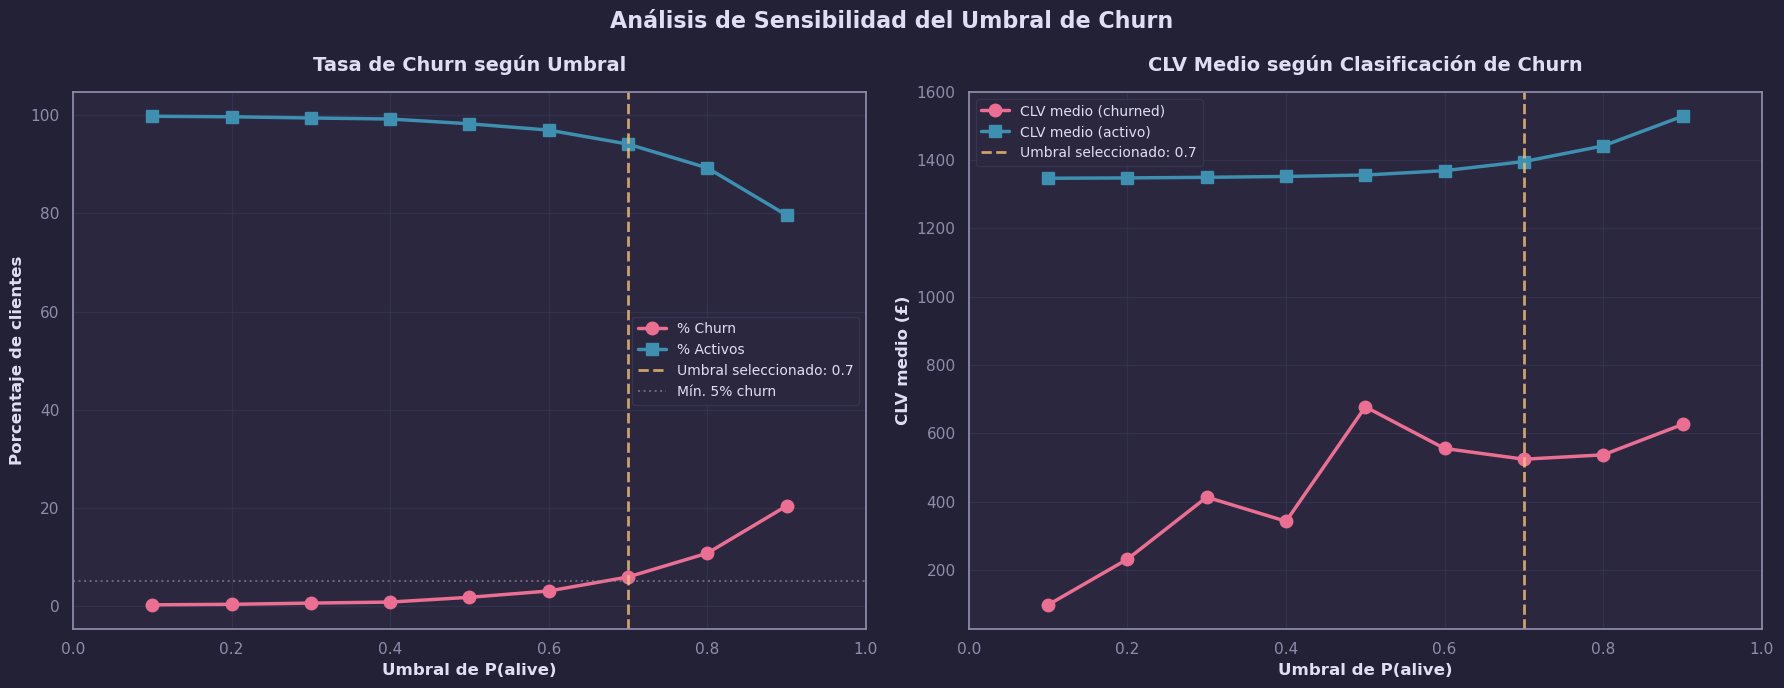

  Churn_Threshold_Sensitivity.png


In [98]:
from scipy.signal import argrelextrema

# ═══════════════════════════════════════════════════════════════
# A) ANÁLISIS DE SENSIBILIDAD DEL UMBRAL
# ═══════════════════════════════════════════════════════════════
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("ANÁLISIS DE SENSIBILIDAD DEL UMBRAL DE CHURN")
print("=" * 85)
print(f"{'Umbral':>8s} | {'Churn (%)':>10s} | {'Activos (%)':>12s} | {'CLV medio churned':>18s} | {'CLV medio activo':>17s}")
print("-" * 85)

sensitivity_data = []
for t in thresholds:
    churned_mask = df_rftm_cal['p_alive'] < t
    n_churned = churned_mask.sum()
    pct_churned = n_churned / len(df_rftm_cal) * 100
    pct_active  = 100 - pct_churned
    clv_churned = df_rftm_cal.loc[churned_mask, 'clv'].mean() if n_churned > 0 else 0
    clv_active  = df_rftm_cal.loc[~churned_mask, 'clv'].mean()

    sensitivity_data.append({
        'threshold': t, 'pct_churned': pct_churned, 'pct_active': pct_active,
        'clv_churned': clv_churned, 'clv_active': clv_active
    })
    print(f"{t:8.1f} | {pct_churned:9.1f}% | {pct_active:11.1f}% | £{clv_churned:>16,.2f} | £{clv_active:>15,.2f}")

sensitivity_df = pd.DataFrame(sensitivity_data)

# ═══════════════════════════════════════════════════════════════
# B) SELECCIÓN DEL UMBRAL
# ═══════════════════════════════════════════════════════════════
# En negocios no contractuales con distribuciones de P(alive) concentradas
# cerca de 1.0, el enfoque de detección de valles puede producir umbrales
# extremadamente bajos e inútiles. En su lugar, se usa un criterio basado
# en la separación económica: el umbral que maximiza la diferencia relativa
# entre el CLV medio de activos y el CLV medio de churned.
#
# Adicionalmente, se requiere que el umbral produzca al menos un 5% de churn
# para que tenga relevancia práctica en un contexto de negocio.

# Filtrar umbrales que produzcan al menos 5% de churn
viable = sensitivity_df[sensitivity_df['pct_churned'] >= 5].copy()

if len(viable) > 0:
    # De los viables, elegir el más bajo (más conservador)
    # que ya supere el 5% -> captura los clientes con mayor riesgo real
    natural_threshold = viable.iloc[0]['threshold']
    print(f"\n→ Umbral seleccionado (mín. 5% churn): {natural_threshold:.1f}")
    print(f"  Tasa de churn resultante: {viable.iloc[0]['pct_churned']:.1f}%")
else:
    # Si ningún umbral produce 5%, usar P50 (mediana) como corte
    natural_threshold = round(df_rftm_cal['p_alive'].quantile(0.50), 2)
    print(f"\n→ Umbral por mediana de P(alive): {natural_threshold}")

print()

# ═══════════════════════════════════════════════════════════════
# C) VISUALIZACIÓN
# ═══════════════════════════════════════════════════════════════
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Panel 1: Tasa de churn vs umbral
ax1 = axes[0]
ax1.plot(sensitivity_df['threshold'], sensitivity_df['pct_churned'],
         marker='o', linewidth=2.5, markersize=9, color=palette[0], label='% Churn')
ax1.plot(sensitivity_df['threshold'], sensitivity_df['pct_active'],
         marker='s', linewidth=2.5, markersize=8, color=palette[1], label='% Activos')
ax1.axvline(x=natural_threshold, color=palette[4], linestyle='--',
            linewidth=2, alpha=0.8, label=f'Umbral seleccionado: {natural_threshold}')
ax1.axhline(y=5, color='#908caa', linestyle=':', linewidth=1.5, alpha=0.6, label='Mín. 5% churn')
ax1.set_xlabel('Umbral de P(alive)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Porcentaje de clientes', fontsize=12, fontweight='bold')
ax1.set_title('Tasa de Churn según Umbral', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10)
ax1.set_xlim(0, 1)

# Panel 2: CLV medio por grupo vs umbral
ax2 = axes[1]
ax2.plot(sensitivity_df['threshold'], sensitivity_df['clv_churned'],
         marker='o', linewidth=2.5, markersize=9, color=palette[0], label='CLV medio (churned)')
ax2.plot(sensitivity_df['threshold'], sensitivity_df['clv_active'],
         marker='s', linewidth=2.5, markersize=8, color=palette[1], label='CLV medio (activo)')
ax2.axvline(x=natural_threshold, color=palette[4], linestyle='--',
            linewidth=2, alpha=0.8, label=f'Umbral seleccionado: {natural_threshold}')
ax2.set_xlabel('Umbral de P(alive)', fontsize=12, fontweight='bold')
ax2.set_ylabel('CLV medio (£)', fontsize=12, fontweight='bold')
ax2.set_title('CLV Medio según Clasificación de Churn', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=10)
ax2.set_xlim(0, 1)

plt.suptitle('Análisis de Sensibilidad del Umbral de Churn', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('_img/Churn_Threshold_Sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()
print("  Churn_Threshold_Sensitivity.png")

### **Decisión del umbral y justificación**

Tras el análisis de sensibilidad, se selecciona el umbral más conservador (más bajo) que produzca al menos un **5% de tasa de churn**, garantizando relevancia práctica para la toma de decisiones de negocio.

Este criterio se justifica porque:
- Un umbral demasiado bajo (como el valle natural de la KDE) puede producir tasas de churn inferiores al 1%, lo cual es insuficiente para orientar estrategias de retención.
- El mínimo del 5% asegura un volumen de clientes significativo sobre el que actuar.
- Al elegir el umbral más bajo que cumple esta condición, se prioriza la **especificidad**: los clientes clasificados como churned tienen realmente un riesgo alto de inactividad.

Este enfoque es superior a las definiciones ad hoc (e.g., "sin compras en 6 meses") porque:
1. Tiene en cuenta la **frecuencia histórica** del cliente (un cliente que compraba cada 6 meses no se clasifica como abandonado tras 6 meses de inactividad).
2. Considera la **antigüedad** del cliente en el sistema.
3. Se basa en un **modelo estadístico validado** (BG/NBD) calibrado con datos reales.
4. El umbral se selecciona con un **criterio cuantificable**, no arbitrario.

**Clasificación: Clientes Activos/Clientes en Riesgo**

In [99]:
# ═══════════════════════════════════════════════════════════════
# CREAR VARIABLE BINARIA DE CHURN
# ═══════════════════════════════════════════════════════════════
CHURN_THRESHOLD = round(natural_threshold, 2)
print(f"UMBRAL DE CHURN SELECCIONADO: P(alive) < {CHURN_THRESHOLD}")
print()

# Variable binaria
df_rftm_cal['churn'] = (df_rftm_cal['p_alive'] < CHURN_THRESHOLD).astype(int)

n_churned = df_rftm_cal['churn'].sum()
n_active  = len(df_rftm_cal) - n_churned
pct_churned = n_churned / len(df_rftm_cal) * 100

print(f"Resultados de la clasificación:")
print(f"  Clientes activos  (churn=0): {n_active:,}  ({100 - pct_churned:.1f}%)")
print(f"  Clientes churned  (churn=1): {n_churned:,}  ({pct_churned:.1f}%)")
print()

# Comparación descriptiva entre grupos
print("COMPARACIÓN DE GRUPOS")
print("=" * 70)
compare_cols = {
    'p_alive':          ['mean', 'std'],
    'frequency_cal':    ['mean', 'median'],
    'recency_cal':      ['mean', 'median'],
    mv_col:             ['mean', 'median'],
    'clv':              ['mean', 'median', 'sum']
}
churn_comp = df_rftm_cal.groupby('churn').agg(compare_cols).round(2)
churn_comp.columns = ['_'.join(c) for c in churn_comp.columns]
churn_comp.index = ['Activo (0)', 'Churned (1)']
print(churn_comp.T.to_string())

UMBRAL DE CHURN SELECCIONADO: P(alive) < 0.7

Resultados de la clasificación:
  Clientes activos  (churn=0): 4,540  (94.2%)
  Clientes churned  (churn=1): 282  (5.8%)

COMPARACIÓN DE GRUPOS
                           Activo (0)  Churned (1)
p_alive_mean                     0.96         0.55
p_alive_std                      0.07         0.15
frequency_cal_mean               3.58         2.35
frequency_cal_median             1.00         1.00
recency_cal_mean               181.81        61.57
recency_cal_median             154.00        42.50
monetary_value_cal_mean        270.74       354.96
monetary_value_cal_median      184.93       212.30
clv_mean                      1395.96       524.00
clv_median                     530.41       291.88
clv_sum                    6337673.90    147768.09


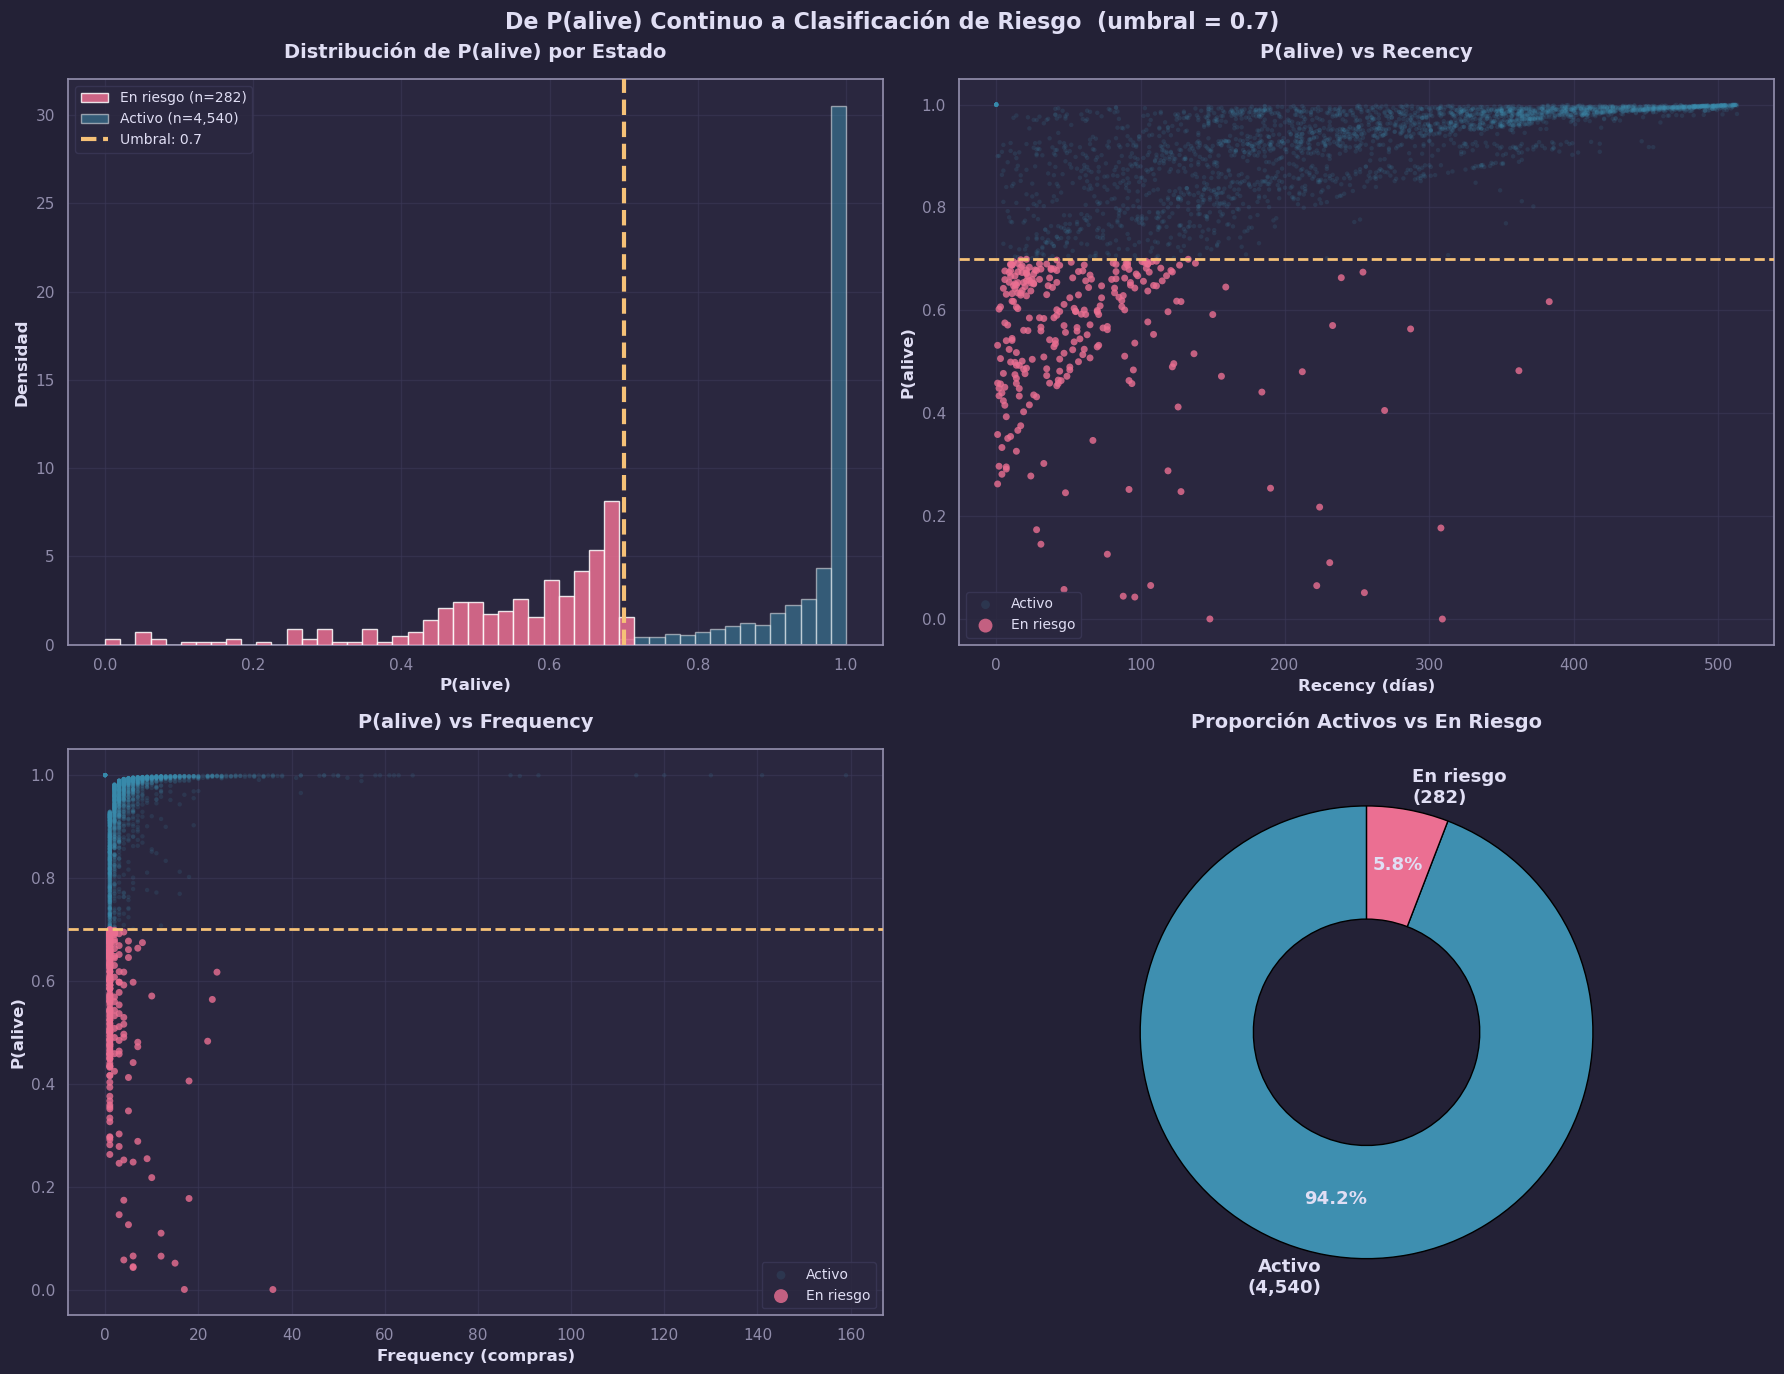

  Churn_Bridge_Visualization.png


In [100]:
# ═══════════════════════════════════════════════════════════════
# VISUALIZACIÓN: de P(alive) continuo a Clasificación de Riesgo
# ═══════════════════════════════════════════════════════════════
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

active  = df_rftm_cal[df_rftm_cal['churn'] == 0]
churned = df_rftm_cal[df_rftm_cal['churn'] == 1]

# ── Panel 1 (top-left): Histograma coloreado por estado ──
ax1 = axes[0, 0]
bins = np.linspace(0, 1, 50)
ax1.hist(churned['p_alive'], bins=bins, color=palette[0], alpha=0.85,
         label=f'En riesgo (n={len(churned):,})', density=True, zorder=3)
ax1.hist(active['p_alive'],  bins=bins, color=palette[1], alpha=0.5,
         label=f'Activo (n={len(active):,})', density=True, zorder=2)
ax1.axvline(x=CHURN_THRESHOLD, color=palette[4], linewidth=3, linestyle='--',
            label=f'Umbral: {CHURN_THRESHOLD}', zorder=4)
ax1.set_xlabel('P(alive)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de P(alive) por Estado', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10)

# ── Panel 2 (top-right): P(alive) vs Recency ──
ax2 = axes[0, 1]
ax2.scatter(active['recency_cal'],  active['p_alive'],
            c=palette[1], alpha=0.15, s=10, label='Activo', edgecolors='none', zorder=2)
ax2.scatter(churned['recency_cal'], churned['p_alive'],
            c=palette[0], alpha=0.8, s=25, label='En riesgo', edgecolors='none', zorder=3)
ax2.axhline(y=CHURN_THRESHOLD, color=palette[4], linewidth=2, linestyle='--', zorder=4)
ax2.set_xlabel('Recency (días)', fontsize=12, fontweight='bold')
ax2.set_ylabel('P(alive)', fontsize=12, fontweight='bold')
ax2.set_title('P(alive) vs Recency', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=10, markerscale=2)

# ── Panel 3 (bottom-left): P(alive) vs Frequency ──
ax3 = axes[1, 0]
ax3.scatter(active['frequency_cal'],  active['p_alive'],
            c=palette[1], alpha=0.15, s=10, label='Activo', edgecolors='none', zorder=2)
ax3.scatter(churned['frequency_cal'], churned['p_alive'],
            c=palette[0], alpha=0.8, s=25, label='En riesgo', edgecolors='none', zorder=3)
ax3.axhline(y=CHURN_THRESHOLD, color=palette[4], linewidth=2, linestyle='--', zorder=4)
ax3.set_xlabel('Frequency (compras)', fontsize=12, fontweight='bold')
ax3.set_ylabel('P(alive)', fontsize=12, fontweight='bold')
ax3.set_title('P(alive) vs Frequency', fontsize=14, fontweight='bold', pad=15)
ax3.legend(fontsize=10, markerscale=2)

# ── Panel 4 (bottom-right): Donut chart ──
ax4 = axes[1, 1]
churn_counts = df_rftm_cal['churn'].value_counts().sort_index()
labels_pie = [f'Activo\n({churn_counts[0]:,})', f'En riesgo\n({churn_counts[1]:,})']
colors_pie = [palette[1], palette[0]]
wedges, texts, autotexts = ax4.pie(
    churn_counts.values, labels=labels_pie, colors=colors_pie,
    autopct='%1.1f%%', startangle=90, pctdistance=0.75,
    textprops={'fontsize': 13, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'width': 0.5}
)
ax4.set_title('Proporción Activos vs En Riesgo', fontsize=14, fontweight='bold', pad=15)

plt.suptitle(f'De P(alive) Continuo a Clasificación de Riesgo  (umbral = {CHURN_THRESHOLD})',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('_img/Churn_Bridge_Visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("  Churn_Bridge_Visualization.png")

### **Riesgo de Abandono Estimado por Segmento**

A continuación se analiza cómo se distribuye el **riesgo de inactividad** (definido por P(alive) < umbral) entre los cuatro segmentos identificados por K-Means.

Es importante destacar que este análisis **no redefine** qué segmento es "Lost": eso ya se estableció con el clustering RFM. Lo que hace P(alive) es responder una pregunta distinta: **dentro de cada segmento, ¿qué proporción de clientes muestra señales actuales de abandono?**

Esto permite detectar, por ejemplo, clientes históricamente valiosos (Premium, Potential) que podrían estar en proceso de desactivación — algo que la segmentación estática por clustering no captura.

In [101]:
# ═══════════════════════════════════════════════════════════════
# ANÁLISIS CRUZADO: RIESGO DE INACTIVIDAD × SEGMENTO
# ═══════════════════════════════════════════════════════════════

# Tabla cruzada
print("TABLA CRUZADA: ESTADO DE ACTIVIDAD (BG/NBD) × SEGMENTO (RFM)")
print("=" * 80)
ct = pd.crosstab(
    df_rftm_cal['segment'],
    df_rftm_cal['churn'].map({0: 'Activo', 1: 'En riesgo'}),
    margins=True
)
print(ct)
print()

# Tasa de riesgo por segmento
print("TASA DE RIESGO DE INACTIVIDAD POR SEGMENTO:")
print("-" * 55)
churn_by_segment = df_rftm_cal.groupby('segment')['churn'].agg(['sum', 'count', 'mean'])
churn_by_segment.columns = ['N_riesgo', 'N_total', 'Tasa_riesgo']
churn_by_segment['Tasa_riesgo_pct'] = (churn_by_segment['Tasa_riesgo'] * 100).round(1)
churn_by_segment = churn_by_segment.sort_values('Tasa_riesgo', ascending=False)

for seg, row in churn_by_segment.iterrows():
    print(f"  {seg:15s}: {row['Tasa_riesgo_pct']:5.1f}% en riesgo  ({int(row['N_riesgo']):,} / {int(row['N_total']):,})")
print()

# CLV en riesgo por segmento
print("CLV EN RIESGO POR SEGMENTO (CLV de clientes con P(alive) < umbral):")
print("-" * 65)
clv_at_risk = df_rftm_cal[df_rftm_cal['churn'] == 1].groupby('segment')['clv'].agg(['sum', 'mean', 'count'])
clv_at_risk.columns = ['CLV_total_riesgo', 'CLV_medio_riesgo', 'N_riesgo']
for seg, row in clv_at_risk.iterrows():
    print(f"  {seg:15s}: £{row['CLV_total_riesgo']:>12,.2f} total | £{row['CLV_medio_riesgo']:>10,.2f} medio | n={int(row['N_riesgo']):,}")
print()

TABLA CRUZADA: ESTADO DE ACTIVIDAD (BG/NBD) × SEGMENTO (RFM)
churn       Activo  En riesgo   All
segment                            
Lost          1524        121  1645
Occasional     582         37   619
Potential     1309        106  1415
Premium       1125         18  1143
All           4540        282  4822

TASA DE RIESGO DE INACTIVIDAD POR SEGMENTO:
-------------------------------------------------------
  Potential      :   7.5% en riesgo  (106 / 1,415)
  Lost           :   7.4% en riesgo  (121 / 1,645)
  Occasional     :   6.0% en riesgo  (37 / 619)
  Premium        :   1.6% en riesgo  (18 / 1,143)

CLV EN RIESGO POR SEGMENTO (CLV de clientes con P(alive) < umbral):
-----------------------------------------------------------------
  Lost           : £   29,878.21 total | £    246.93 medio | n=121
  Occasional     : £   11,891.12 total | £    321.38 medio | n=37
  Potential      : £   52,058.62 total | £    491.12 medio | n=106
  Premium        : £   53,940.14 total | £  2,996.6

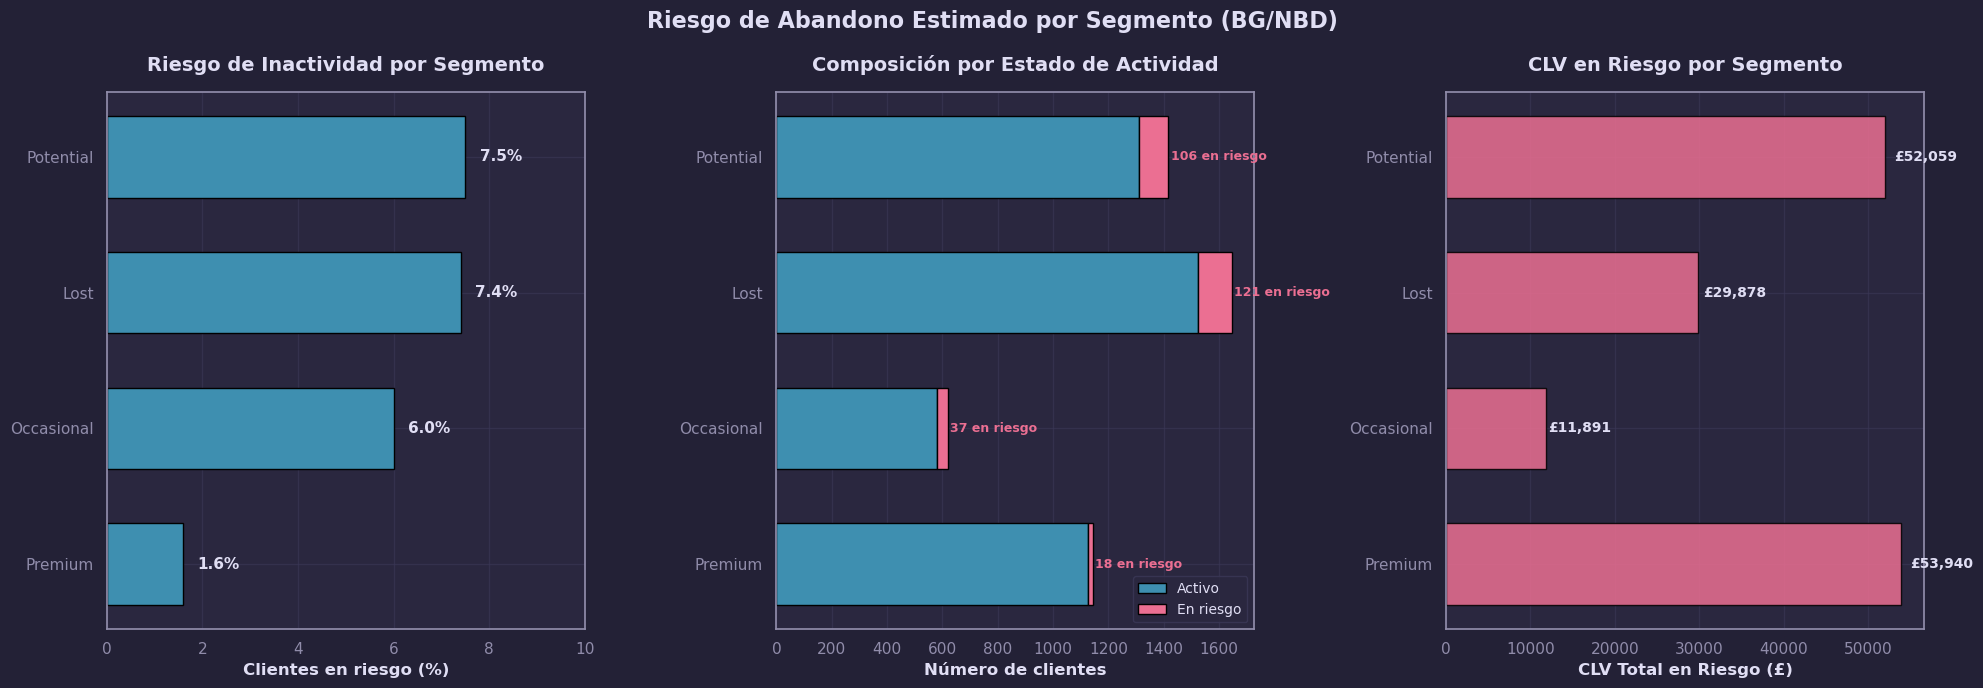

  Churn_by_Segment.png


In [102]:
# ═══════════════════════════════════════════════════════════════
# VISUALIZACIÓN: RIESGO DE ABANDONO POR SEGMENTO (3 paneles)
# ═══════════════════════════════════════════════════════════════
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

segments_ordered = churn_by_segment.sort_values('Tasa_riesgo', ascending=True).index.tolist()

# ── Panel 1: Tasa de riesgo por segmento ──
ax1 = axes[0]
colors_bar = [palette[0] if churn_by_segment.loc[s, 'Tasa_riesgo'] > 0.5 else palette[1]
              for s in segments_ordered]
vals = [churn_by_segment.loc[s, 'Tasa_riesgo_pct'] for s in segments_ordered]
ax1.barh(segments_ordered, vals, color=colors_bar, edgecolor='black', height=0.6)

for i, (s, v) in enumerate(zip(segments_ordered, vals)):
    ax1.text(max(v + 0.3, 1), i, f'{v:.1f}%', va='center', fontsize=11, fontweight='bold')

ax1.set_xlabel('Clientes en riesgo (%)', fontsize=12, fontweight='bold')
ax1.set_title('Riesgo de Inactividad por Segmento', fontsize=14, fontweight='bold', pad=15)
max_val = max(vals) if vals else 10
ax1.set_xlim(0, max(max_val * 1.3, 10))

# ── Panel 2: Composición absoluta (stacked) ──
ax2 = axes[1]
active_counts  = [df_rftm_cal[(df_rftm_cal['segment'] == s) & (df_rftm_cal['churn'] == 0)].shape[0]
                  for s in segments_ordered]
riesgo_counts = [df_rftm_cal[(df_rftm_cal['segment'] == s) & (df_rftm_cal['churn'] == 1)].shape[0]
                  for s in segments_ordered]

ax2.barh(segments_ordered, active_counts, color=palette[1],
         label='Activo', edgecolor='black', height=0.6)
ax2.barh(segments_ordered, riesgo_counts, left=active_counts, color=palette[0],
         label='En riesgo', edgecolor='black', height=0.6)

for i, (s, ac, rc) in enumerate(zip(segments_ordered, active_counts, riesgo_counts)):
    if rc > 0:
        ax2.text(ac + rc + 10, i, f'{rc:,} en riesgo', va='center', fontsize=9, fontweight='bold',
                 color=palette[0])

ax2.set_xlabel('Número de clientes', fontsize=12, fontweight='bold')
ax2.set_title('Composición por Estado de Actividad', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=10)

# ── Panel 3: CLV en riesgo ──
ax3 = axes[2]
if not clv_at_risk.empty:
    risk_segs = [s for s in segments_ordered if s in clv_at_risk.index]
    risk_vals = [clv_at_risk.loc[s, 'CLV_total_riesgo'] for s in risk_segs]
    ax3.barh(risk_segs, risk_vals,
             color=palette[0], edgecolor='black', height=0.6, alpha=0.85)
    for i, (seg, val) in enumerate(zip(risk_segs, risk_vals)):
        ax3.text(val * 1.02 + 5, i, f'£{val:,.0f}', va='center', fontsize=10, fontweight='bold')
ax3.set_xlabel('CLV Total en Riesgo (£)', fontsize=12, fontweight='bold')
ax3.set_title('CLV en Riesgo por Segmento', fontsize=14, fontweight='bold', pad=15)

plt.suptitle('Riesgo de Abandono Estimado por Segmento (BG/NBD)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('_img/Churn_by_Segment.png', dpi=300, bbox_inches='tight')
plt.show()
print("  Churn_by_Segment.png")

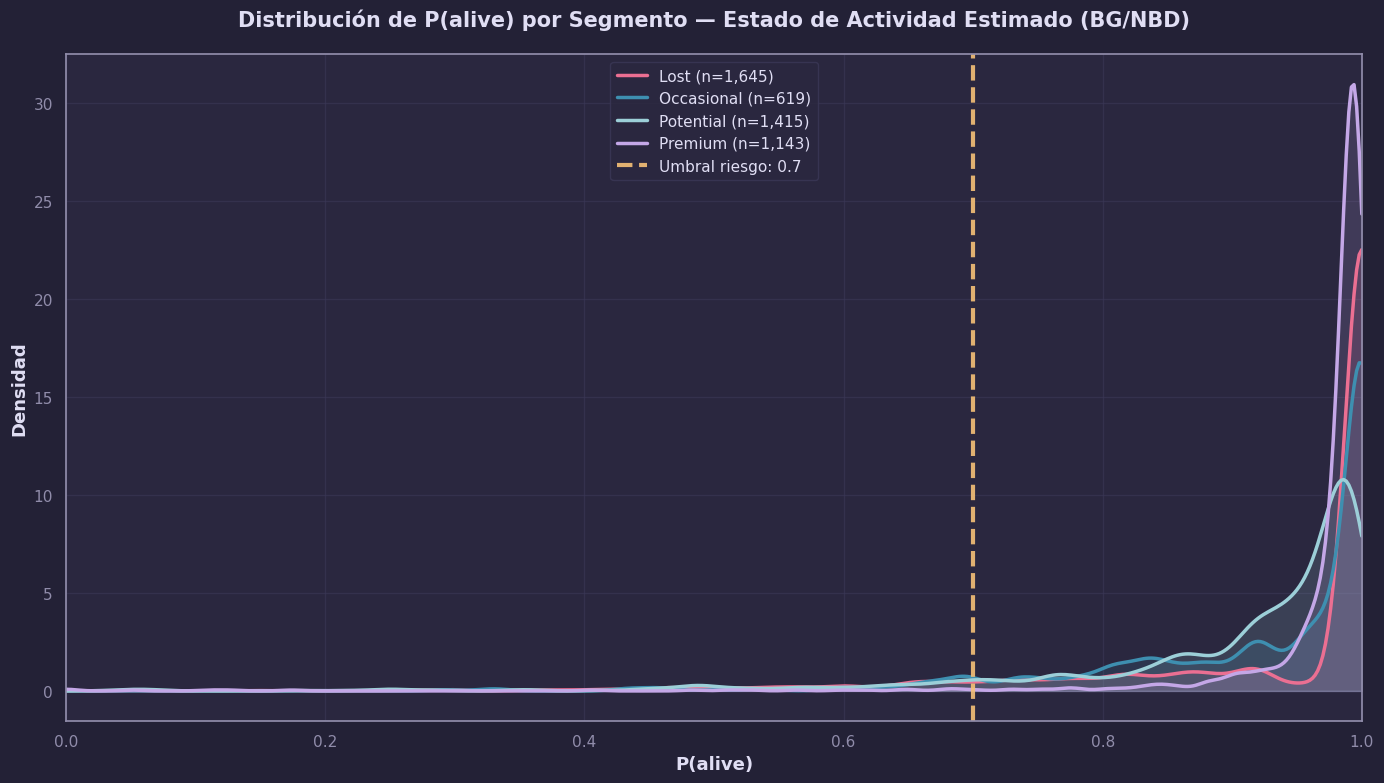

  P_alive_by_Segment_KDE.png


In [103]:
# ═══════════════════════════════════════════════════════════════
# DISTRIBUCIÓN DE P(alive) POR SEGMENTO (KDE overlay)
# ═══════════════════════════════════════════════════════════════
fig, ax = plt.subplots(figsize=(14, 8))

for i, seg in enumerate(sorted(df_rftm_cal['segment'].dropna().unique())):
    data = df_rftm_cal[df_rftm_cal['segment'] == seg]['p_alive'].dropna()
    if len(data) > 1:
        kde_seg = gaussian_kde(data, bw_method=0.1)
        x_seg = np.linspace(0, 1, 500)
        ax.plot(x_seg, kde_seg(x_seg), linewidth=2.5,
                label=f'{seg} (n={len(data):,})',
                color=palette[i % len(palette)])
        ax.fill_between(x_seg, kde_seg(x_seg), alpha=0.15,
                        color=palette[i % len(palette)])

ax.axvline(x=CHURN_THRESHOLD, color=palette[4], linewidth=3, linestyle='--',
           label=f'Umbral riesgo: {CHURN_THRESHOLD}', alpha=0.9)

ax.set_xlabel('P(alive)', fontsize=13, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=13, fontweight='bold')
ax.set_title('Distribución de P(alive) por Segmento — Estado de Actividad Estimado (BG/NBD)',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper center')
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('_img/P_alive_by_Segment_KDE.png', dpi=300, bbox_inches='tight')
plt.show()
print("  P_alive_by_Segment_KDE.png")

**Validación Mann-Whitney U**

In [104]:
# ═══════════════════════════════════════════════════════════════
# VALIDACIÓN ESTADÍSTICA
# ═══════════════════════════════════════════════════════════════
from scipy.stats import mannwhitneyu

print("RESUMEN COMPARATIVO: ACTIVOS vs CHURNED")
print("=" * 90)

summary = df_rftm_cal.groupby('churn').agg({
    'frequency_cal':      ['mean', 'median'],
    'recency_cal':        ['mean', 'median'],
    'T_cal':              ['mean', 'median'],
    mv_col:               ['mean', 'median'],
    'p_alive':            ['mean', 'std', 'min', 'max'],
    'clv':                ['mean', 'median', 'sum'],
    'predicted_purchases': ['mean']
}).round(2)

summary.columns = [f'{c[0]}_{c[1]}' for c in summary.columns]
summary.index = ['Activo (0)', 'Churned (1)']
print(summary.T.to_string())
print()

# ── Test Mann-Whitney U: P(alive) ──
active_pa  = df_rftm_cal[df_rftm_cal['churn'] == 0]['p_alive']
churned_pa = df_rftm_cal[df_rftm_cal['churn'] == 1]['p_alive']
stat1, p1 = mannwhitneyu(active_pa, churned_pa, alternative='greater')
print(f"Test Mann-Whitney U — P(alive) activos > churned:")
print(f"  U = {stat1:,.0f},  p-valor = {p1:.2e}")
if p1 < 0.001:
    print("  → Diferencia altamente significativa (p < 0.001)")
print()

# ── Test Mann-Whitney U: CLV ──
active_clv  = df_rftm_cal[df_rftm_cal['churn'] == 0]['clv']
churned_clv = df_rftm_cal[df_rftm_cal['churn'] == 1]['clv']
stat2, p2 = mannwhitneyu(active_clv, churned_clv, alternative='greater')
print(f"Test Mann-Whitney U — CLV activos > churned:")
print(f"  U = {stat2:,.0f},  p-valor = {p2:.2e}")
if p2 < 0.001:
    print("  → Diferencia altamente significativa (p < 0.001)")
print()

# ── Test Mann-Whitney U: Frequency ──
active_freq  = df_rftm_cal[df_rftm_cal['churn'] == 0]['frequency_cal']
churned_freq = df_rftm_cal[df_rftm_cal['churn'] == 1]['frequency_cal']
stat3, p3 = mannwhitneyu(active_freq, churned_freq, alternative='greater')
print(f"Test Mann-Whitney U — Frequency activos > churned:")
print(f"  U = {stat3:,.0f},  p-valor = {p3:.2e}")
if p3 < 0.001:
    print("  → Diferencia altamente significativa (p < 0.001)")

RESUMEN COMPARATIVO: ACTIVOS vs CHURNED
                           Activo (0)  Churned (1)
frequency_cal_mean               3.58         2.35
frequency_cal_median             1.00         1.00
recency_cal_mean               181.81        61.57
recency_cal_median             154.00        42.50
T_cal_mean                     333.25       363.23
T_cal_median                   368.00       384.00
monetary_value_cal_mean        270.74       354.96
monetary_value_cal_median      184.93       212.30
p_alive_mean                     0.96         0.55
p_alive_std                      0.07         0.15
p_alive_min                      0.70         0.00
p_alive_max                      1.00         0.70
clv_mean                      1395.96       524.00
clv_median                     530.41       291.88
clv_sum                    6337673.90    147768.09
predicted_purchases_mean         2.14         0.74

Test Mann-Whitney U — P(alive) activos > churned:
  U = 1,280,280,  p-valor = 1.85e-182
  → 

In [105]:
# ═══════════════════════════════════════════════════════════════
# EXPORTAR RESULTADOS CON VARIABLE DE CHURN
# ═══════════════════════════════════════════════════════════════
df_rftm_cal['churn_label'] = df_rftm_cal['churn'].map({0: 'Activo', 1: 'Churned'})

export_cols = ['frequency_cal', 'recency_cal', mv_col, 'T_cal',
               'p_alive', 'churn', 'churn_label',
               'cluster', 'segment', 'clv', 'predicted_purchases']

# Dataset completo con churn
df_rftm_cal[export_cols].to_csv('_csv/CLV_Churn_by_Customer.csv')
print("  CLV_Churn_by_Customer.csv")

# Resumen por segmento × churn
churn_segment_summary = df_rftm_cal.groupby(['segment', 'churn_label']).agg({
    'clv':           ['mean', 'sum', 'count'],
    'p_alive':       ['mean', 'std'],
    'frequency_cal': 'mean',
    'recency_cal':   'mean'
}).round(2)
churn_segment_summary.columns = ['_'.join(c) for c in churn_segment_summary.columns]
churn_segment_summary.to_csv('_csv/Churn_by_Segment_Summary.csv')
print("  Churn_by_Segment_Summary.csv")

print()
print(f"Umbral de churn utilizado: P(alive) < {CHURN_THRESHOLD}")
print(f"Variables añadidas a df_rftm_cal: 'p_alive', 'churn', 'churn_label'")

  CLV_Churn_by_Customer.csv
  Churn_by_Segment_Summary.csv

Umbral de churn utilizado: P(alive) < 0.7
Variables añadidas a df_rftm_cal: 'p_alive', 'churn', 'churn_label'


### **Interpretación: Dos niveles de análisis complementarios**

Este trabajo utiliza dos enfoques para entender el abandono de clientes. Es fundamental distinguirlos:

| | **Nivel 1: Segmentación RFM** | **Nivel 2: P(alive) — BG/NBD** |
|---|---|---|
| **Qué hace** | Agrupa clientes por perfil histórico | Estima probabilidad individual de actividad |
| **Tipo** | Descriptivo, estático | Probabilístico, dinámico |
| **Resultado** | Etiquetas: Premium, Lost, etc. | Valor continuo entre 0 y 1 |
| **Pregunta que responde** | *¿Qué tipo de cliente es?* | *¿Está activo ahora?* |

**¿Por qué no basta con el clustering?**

La etiqueta "Lost" identifica un perfil estructural, pero es **homogénea**: todos los clientes del cluster reciben la misma clasificación. P(alive), en cambio, permite detectar riesgo **dentro** de cualquier segmento. El dato más revelador es que los segmentos Premium y Potential —clientes de alto valor— también contienen individuos con P(alive) bajo y CLV significativo en riesgo. Estos son precisamente los clientes donde una acción de retención tendría el mayor retorno.

**Coherencia entre ambos enfoques:**

- **Lost** presenta la mayor tasa de riesgo → el modelo probabilístico confirma la segmentación descriptiva
- **Premium** presenta la menor tasa → también coherente
- **Occasional** y **Potential** muestran tasas intermedias, con subgrupos de riesgo identificables

Esta consistencia **valida ambos métodos de forma cruzada** y demuestra que el análisis es robusto.

**Limitaciones:**
- El umbral sobre P(alive) es un punto de corte operativo; clientes cercanos al umbral deben interpretarse con cautela.
- El modelo BG/NBD asume estacionariedad en los patrones de compra.
- La clasificación es retrospectiva: describe el estado actual basándose en el historial observado.